# 3DGS-DIFF Notebook 

Current goals: <br />
- Experiment with rendering of objects <br />
- From different views <br />
- Take test views from dataset (defined poses) - use for rendering: currently not possible, due to errors with pre training with eval flag that come up on training of contrastive features <br />
- Select Pose around scene - similar to gui <br />


# Imports and arguments merging

In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature

from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None): # 
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

# Hyperparameters - Paths Setup

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/305b90ae-c' ##(3dgs pre training with only training views)
# MODEL_PATH = './output/ca50c0c0-7'   ## train/test split every 8th frame in test
# MODEL_PATH = './output/e04642dd-d'   ## train/test split every 8th frame in train
# MODEL_PATH = './output/3e8f1b4b-c'   ## train/test split ,only 8 train images, same table side ?
MODEL_PATH = './output/0b7d9c09-2'   ## train/test split ,only 8 train images, same table side

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation - Scene and Models Initialization

In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = False

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/0b7d9c09-2/cfg_args
Config file found: ./output/0b7d9c09-2/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 303/303
one_side
Loading Training Cameras
Loading Test Cameras


In [4]:
# import torch
# print(torch.cuda.is_available())
# print(torch.version.cuda)
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


In [5]:
# !nvidia-smi

# Scale Normalization with QuantileTransformer

In [6]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    all_scales.append(cam.mask_scales)
all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

18.12681 ?


/home/stud/ribe/miniconda3/envs/gaussian_splatting_new/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (942). n_quantiles is set to n_samples.
  warnings.warn(


In [7]:
all_scales.max()

tensor(18.1268, grad_fn=<MaxBackward1>)

In [8]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [9]:
upper_bound_scale

18.12681007385254

In [10]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Prepare for segmentation

In [11]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 8 views in the dataset.
18.12681007385254


# Feature Conditioning and Similarity Query

Rerun feature rendering when changing query

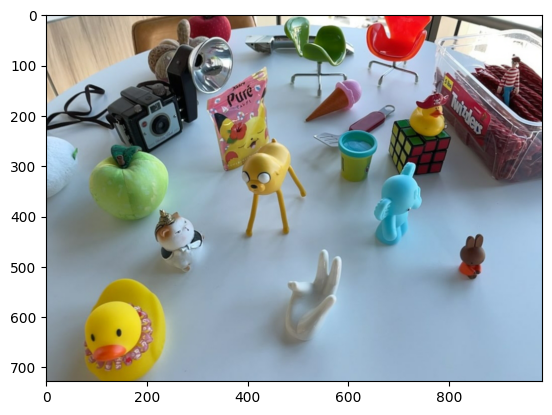

In [12]:
ref_img_camera_id = 7 # can change here
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

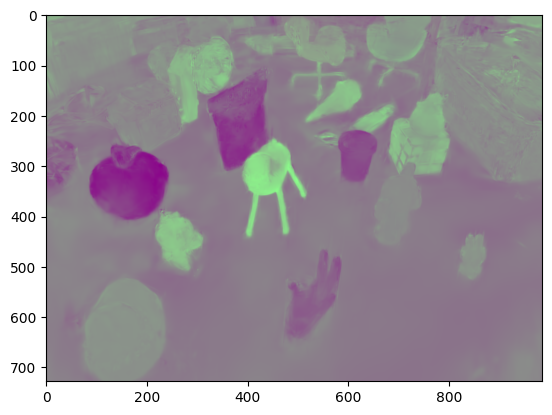

In [13]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1.]).cuda()

    gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    # plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy()) # ? img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    img = scale_conditioned_feature[:, :, :3].detach().cpu().numpy() ### new fix 07.2025
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.imshow(img)


# COORDINATE SELECTION

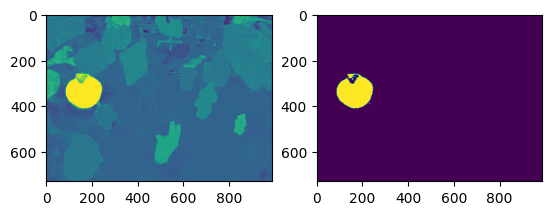

In [14]:
# query_index = (300, 600) # cup on ref_img_camera_id = 7 , ID = 63
# query_index = (400, 700) # elephant on ref_img_camera_id = 7 , ID = 49
# query_index = (600, 200) # duck on ref_img_camera_id = 7 , ID = 70
# query_index = (500, 830) # rabbit on ref_img_camera_id = 7 , ID = 43
query_index = (300, 200) # apple on ref_img_camera_id = 7 , ID = 36
# query_index = (200, 200) # camera on ref_img_camera_id = 7 , ID = 15
# query_index = (150, 600) # cone on ref_img_camera_id = 7 , ID = 55
# query_index = (600, 500) # hand on ref_img_camera_id = 7 , ID = 33
# query_index = (310, 400) # dog on ref_img_camera_id = 7 , ID = 67



query_index = (
    int(query_index[0] / view.image_height * view.feature_height),
    int(query_index[1] / view.image_width * view.feature_width),
               )

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)

plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)

In [15]:
# SHOW PCA in 2D

# # CHW -> PCA dimension reduction DHW (D=3)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)


# # t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
# t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

# t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
# t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
# plt.imshow(t)

# Cluster in 2D

Downsample features for clustering and normalize features across feature dim:

In [16]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (128, 128), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

run hdbscan clustering:

In [17]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

/home/stud/ribe/miniconda3/envs/gaussian_splatting_new/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stud/ribe/miniconda3/envs/gaussian_splatting_new/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


Got 41 clusters from previous cell and one noise class -1

# Visualize clusters:

In [18]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

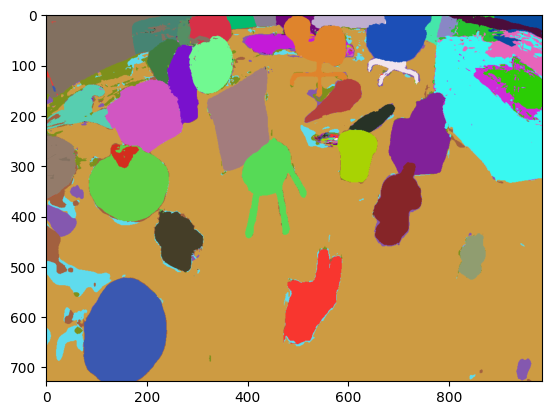

In [19]:
plt.imshow(colored_labels)

# Segmentation in 3D

In [20]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = point_features * gates.unsqueeze(0)


Apply query to 3d points:

In [21]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)

similarities[similarities < 0.5] = 0

Render similarities as grayscale overlay, object bright, background dim:

In [22]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_similarities = render(cameras[5], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']

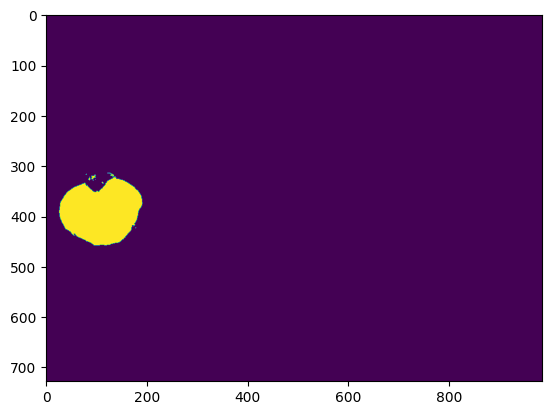

In [23]:
plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu() > 0.6)

In [24]:
try:
    scene_gaussians.roll_back()
except:
    pass
scene_gaussians.segment(similarities > 0.75)

In [25]:
# save the segmentation mask
name = 'precomputed_mask'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.75, f'./segmentation_res/{name}.pt')

# NEW: Consistency Check: Verify Object IDs in object_mask/

In [26]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt

# paths
dataset_root = "/storage/user/ribe/figurines"
mask_dir = os.path.join(dataset_root, "object_mask")
rgb_dir = os.path.join(dataset_root, "images")

mask_files = sorted(glob(os.path.join(mask_dir, "frame_*.png")))
rgb_files  = sorted(glob(os.path.join(rgb_dir, "frame_*.jpg")))

print(f"Found {len(mask_files)} mask frames, {len(rgb_files)} RGB frames")

#1: Collect unique IDs per frame 
id_per_frame = {}
for mf in mask_files:
    mask = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
    unique_ids = np.unique(mask)
    id_per_frame[os.path.basename(mf)] = unique_ids

print("\n example IDs:")
for k, v in list(id_per_frame.items())[:5]:
    print(f"{k}: {v}")

# 2: Global ID set
all_ids = np.unique(np.concatenate(list(id_per_frame.values())))
print("\nGlobal set of IDs across all frames:", all_ids)

# 3: Visualization helper 
def show_overlay(idx, alpha=0.5):
    rgb = cv2.cvtColor(cv2.imread(rgb_files[idx]), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_files[idx], cv2.IMREAD_UNCHANGED)

    # apply random color per ID
    ids = np.unique(mask)
    color_map = {i: np.random.randint(0, 255, 3) for i in ids}
    mask_color = np.zeros_like(rgb)
    for i in ids:
        mask_color[mask == i] = color_map[i]

    overlay = cv2.addWeighted(rgb, 1 - alpha, mask_color, alpha, 0)

    plt.figure(figsize=(10, 5))
    plt.sub


Found 299 mask frames, 299 RGB frames



 example IDs:
frame_00001.png: [ 0  5 15 25 32 33 36 40 41 42 43 45 47 49 50 52 53 54 55 56 57 59 60 63
 65 67 70 75 91]
frame_00002.png: [ 0  5 15 25 32 33 36 40 41 42 43 45 47 49 50 52 53 54 55 56 57 59 60 63
 65 67 70 75 91]
frame_00003.png: [ 0  5 15 25 32 33 36 40 41 42 43 45 47 49 50 52 53 54 55 56 57 59 60 63
 65 67 70 75 91]
frame_00004.png: [ 0  5 15 32 33 36 40 41 42 43 45 47 49 50 52 54 55 56 57 59 60 63 65 67
 70 91]
frame_00005.png: [ 0  5 15 32 33 36 40 41 42 43 45 47 49 50 52 54 55 56 57 59 63 65 67 70
 91]

Global set of IDs across all frames: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  70  71  72  73
  74  75  81  82  84  85  86  87  88  89  90  91  92  93  94  95  96  99
 100 101 103 104 106 107 108 111 113 116 117 118 119 120 121 122 123

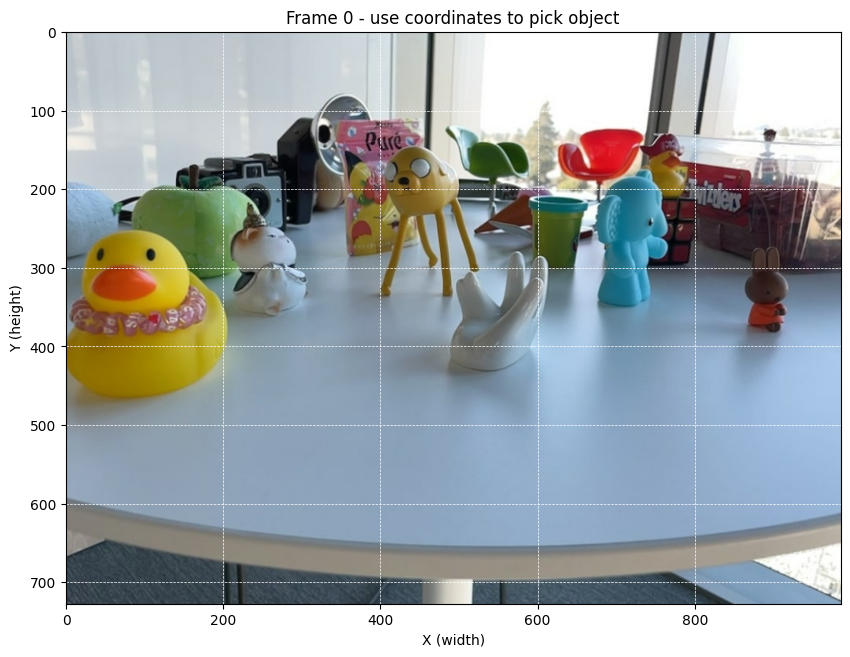

Object ID at (430,200) in frame 0: 67


67

In [27]:
import matplotlib.pyplot as plt
import cv2

def show_frame_with_coords(frame_idx):
    rgb = cv2.cvtColor(cv2.imread(rgb_files[frame_idx]), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb)
    plt.title(f"Frame {frame_idx} - use coordinates to pick object")
    plt.xlabel("X (width)")
    plt.ylabel("Y (height)")
    plt.grid(True, color='white', linestyle='--', linewidth=0.5)  # optional grid
    plt.show()

def get_id_at_pixel(frame_idx, x, y):
    mask = cv2.imread(mask_files[frame_idx], cv2.IMREAD_UNCHANGED)
    obj_id = mask[y, x]
    print(f"Object ID at ({x},{y}) in frame {frame_idx}: {obj_id}")
    return obj_id

# Example usage:
show_frame_with_coords(0)        # see frame 0 with coordinate grid
get_id_at_pixel(0, 430, 200)    # check object at chosen coordinate [x, y]


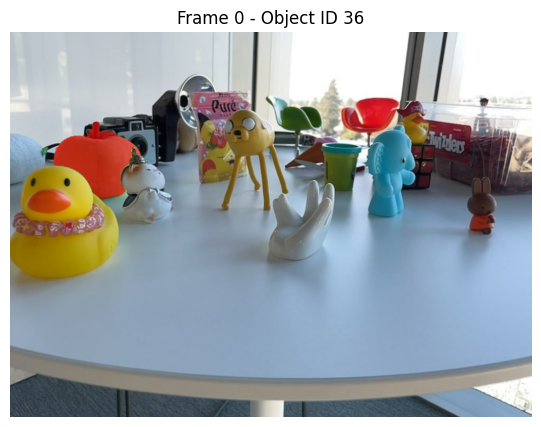

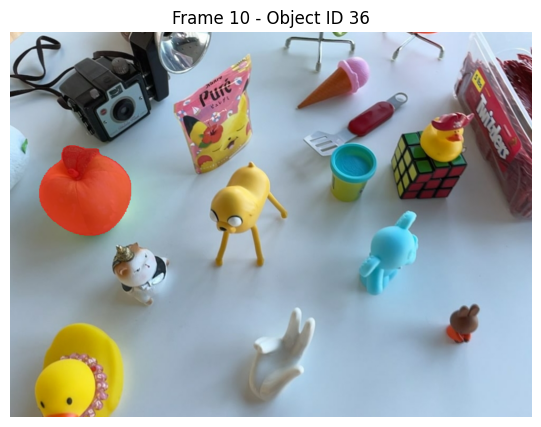

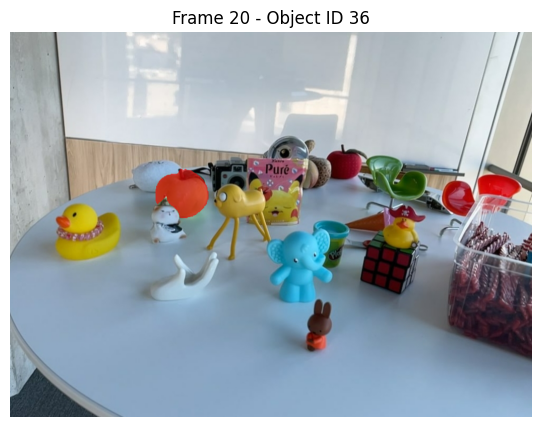

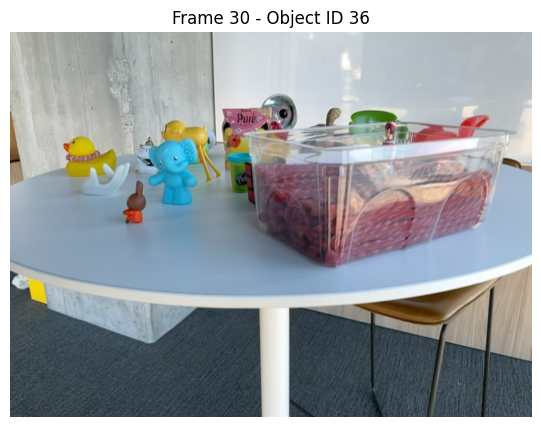

In [28]:
# 4: Overlay only a specific object ID (e.g. 25) 
def show_object_id(idx, obj_id, alpha=0.6):
    rgb = cv2.cvtColor(cv2.imread(rgb_files[idx]), cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_files[idx], cv2.IMREAD_UNCHANGED)

    # Create binary mask for this object
    obj_mask = (mask == obj_id).astype(np.uint8)

    # Create a red overlay only where mask == obj_id
    overlay = rgb.copy()
    overlay[obj_mask == 1] = [255, 0, 0]  # red

    blended = cv2.addWeighted(rgb, 1 - alpha, overlay, alpha, 0)

    plt.figure(figsize=(10, 5))
    plt.imshow(blended)
    plt.title(f"Frame {idx} - Object ID {obj_id}")
    plt.axis("off")
    plt.show()

obj_id = 36
# Example usage
show_object_id(0, obj_id)   # check first frame
show_object_id(10, obj_id)  # check frame 10
show_object_id(20, obj_id)  # check frame 20
show_object_id(30, obj_id)  # check frame 30
# show_object_id(200, obj_id)  # check frame 50


obj_id = 63 , cup <br />
obj_id = 70 , duck <br />
obj_id = 49 , elephant <br />
obj_id = 55 , cone <br />
obj_id = 15 , camera <br />
obj_id = 36 , apple <br />
obj_id = 43 , rabbit <br />
obj_id = 33 , hand <br />
obj_id = 67 , dog <br />



# #TODO: Mask segmentation metric evaluation - IOU

In [397]:
import numpy as np

def compute_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    return intersection / union if union > 0 else float("nan")

def evaluate_object_iou(obj_id, mask_files, rendered_similarities_list, tau, selected_indices):
    ious = []
    skipped = 0
    used = 0
    for frame_idx in selected_indices:
        mf = mask_files[frame_idx]
        sim_map = rendered_similarities_list[frame_idx]

        # --- GT mask ---
        mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
        gt_mask = (mask_gt_img == obj_id).astype(np.uint8)

        if gt_mask.sum() == 0:
            print(f"Frame {frame_idx:03d}: object {obj_id} not visible --> skipped")
            skipped += 1
            continue

        # --- Prediction ---
        pred_mask = (sim_map > tau).astype(np.uint8)

        # --- IoU ---
        iou = compute_iou(gt_mask, pred_mask)
        ious.append(iou)
        used += 1

        print(f"Frame {frame_idx:03d}: IoU = {iou:.3f}")

    print("\nSummary:")
    print(f"Frames used   : {used}")
    print(f"Frames skipped: {skipped}")
    if len(ious) > 0:
        print(f"Mean IoU: {np.nanmean(ious):.3f}")
        print(f"Min IoU : {np.nanmin(ious):.3f}")
    else:
        print("No valid frames where object was visible.")

    return np.array(ious)


#  Select only the meaningful frames (30 total) 
selected_indices = list(range(16, 23)) + list(range(32, 45)) + list(range(105, 115))
print(f"Using {len(selected_indices)} selected frames: {selected_indices}")

# Combine all cameras in order corresponding to mask_files
all_cameras = scene.getTrainCameras() + scene.getTestCameras()
print(f"Total cameras: {len(all_cameras)}, total mask frames: {len(mask_files)}")

#Build rendered_similarities_list for all frames 
rendered_similarities_list = []
for idx, (mf, cam) in enumerate(zip(mask_files, all_cameras)):
    out = render(
        cam,
        scene_gaussians,
        pipeline.extract(args),
        background,
        override_color=similarities.unsqueeze(-1).repeat([1, 3])
    )
    sim_map = out['render']  # [3,H,W]
    sim_map = sim_map.permute(1, 2, 0)[:, :, 0]  # take first channel, shape [H,W]
    sim_map = sim_map.detach().cpu().numpy()
    rendered_similarities_list.append(sim_map)

print(f"Built rendered_similarities_list with {len(rendered_similarities_list)} frames")

# Evaluate IoU for the object on selected frames only 
# obj_id = 49
ious = evaluate_object_iou(
    obj_id=obj_id,
    mask_files=mask_files,
    rendered_similarities_list=rendered_similarities_list,
    tau=0.0,
    selected_indices=selected_indices
)


Using 30 selected frames: [16, 17, 18, 19, 20, 21, 22, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114]
Total cameras: 303, total mask frames: 299
Built rendered_similarities_list with 299 frames
Frame 016: IoU = 0.200
Frame 017: IoU = 0.185
Frame 018: IoU = 0.186
Frame 019: IoU = 0.180
Frame 020: IoU = 0.168
Frame 021: IoU = 0.143
Frame 022: IoU = 0.129
Frame 032: IoU = 0.165
Frame 033: IoU = 0.125
Frame 034: IoU = 0.193
Frame 035: IoU = 0.173
Frame 036: IoU = 0.175
Frame 037: IoU = 0.189
Frame 038: IoU = 0.222
Frame 039: IoU = 0.211
Frame 040: IoU = 0.226
Frame 041: IoU = 0.228
Frame 042: IoU = 0.206
Frame 043: IoU = 0.199
Frame 044: IoU = 0.181
Frame 105: IoU = 0.240
Frame 106: IoU = 0.221
Frame 107: object 33 not visible --> skipped
Frame 108: object 33 not visible --> skipped
Frame 109: IoU = 0.060
Frame 110: IoU = 0.053
Frame 111: IoU = 0.053
Frame 112: IoU = 0.034
Frame 113: IoU = 0.031
Frame 114: IoU = 0.050

Summary:
Frames 

with normalization:

In [398]:
# import numpy as np
# import cv2

# def compute_iou(gt_mask, pred_mask):
#     intersection = np.logical_and(gt_mask, pred_mask).sum()
#     union = np.logical_or(gt_mask, pred_mask).sum()
#     return intersection / union if union > 0 else float("nan")

# def normalize_map(sim_map):
#     sim_min, sim_max = sim_map.min(), sim_map.max()
#     if sim_max - sim_min > 1e-6:
#         return (sim_map - sim_min) / (sim_max - sim_min)
#     else:
#         return np.zeros_like(sim_map)

# def evaluate_object_iou(obj_id, mask_files, rendered_similarities_list, tau=0.5, normalize=True):
#     ious = []
#     skipped = 0
#     used = 0
#     for frame_idx, (mf, sim_map) in enumerate(zip(mask_files, rendered_similarities_list)):
#         # --- GT mask ---
#         mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
#         gt_mask = (mask_gt_img == obj_id).astype(np.uint8)

#         if gt_mask.sum() == 0:
#             print(f"Frame {frame_idx:03d}: object {obj_id} not visible → skipped")
#             skipped += 1
#             continue

#         # --- Prediction ---
#         if normalize:
#             sim_map = normalize_map(sim_map)
#         pred_mask = (sim_map > tau).astype(np.uint8)

#         # --- IoU ---
#         iou = compute_iou(gt_mask, pred_mask)
#         ious.append(iou)
#         used += 1

#         print(f"Frame {frame_idx:03d}: IoU = {iou:.3f}")

#     print("\nSummary:")
#     print(f"Frames used   : {used}")
#     print(f"Frames skipped: {skipped}")
#     if len(ious) > 0:
#         print(f"Mean IoU: {np.nanmean(ious):.3f}")
#         print(f"Min IoU : {np.nanmin(ious):.3f}")
#     else:
#         print("No valid frames where object was visible.")

#     return np.array(ious)

# # --- Build rendered_similarities_list for all frames ---
# all_cameras = scene.getTrainCameras() + scene.getTestCameras()
# print(f"Total cameras: {len(all_cameras)}, total mask frames: {len(mask_files)}")

# rendered_similarities_list = []
# for idx, (mf, cam) in enumerate(zip(mask_files, all_cameras)):
#     out = render(
#         cam,
#         scene_gaussians,
#         pipeline.extract(args),
#         background,
#         override_color=similarities.unsqueeze(-1).repeat([1, 3])
#     )
#     sim_map = out['render']  # [3,H,W]
#     sim_map = sim_map.permute(1, 2, 0)[:, :, 0]  # take first channel, shape [H,W]
#     sim_map = sim_map.detach().cpu().numpy()
#     rendered_similarities_list.append(sim_map)

# print(f"Built rendered_similarities_list with {len(rendered_similarities_list)} frames")

# # --- Evaluate IoU for the object ---
# obj_id = 63
# ious = evaluate_object_iou(
#     obj_id=obj_id,
#     mask_files=mask_files,
#     rendered_similarities_list=rendered_similarities_list,
#     tau=0.2,   # still needed to binarize after normalization
#     normalize=True
# )


sanity check visualization

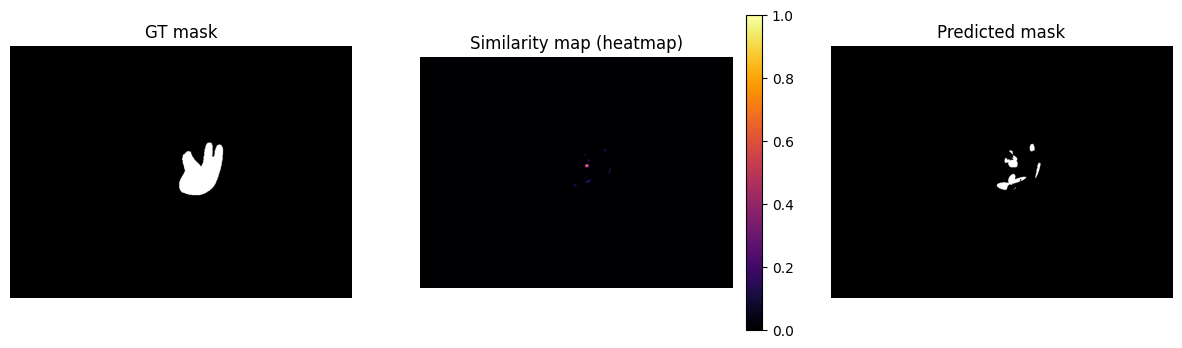

Frame 0: IoU = 0.191


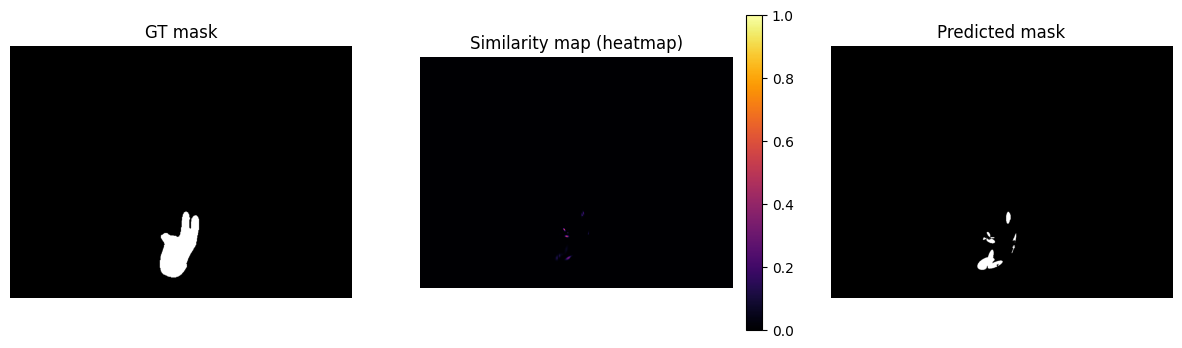

Frame 5: IoU = 0.201


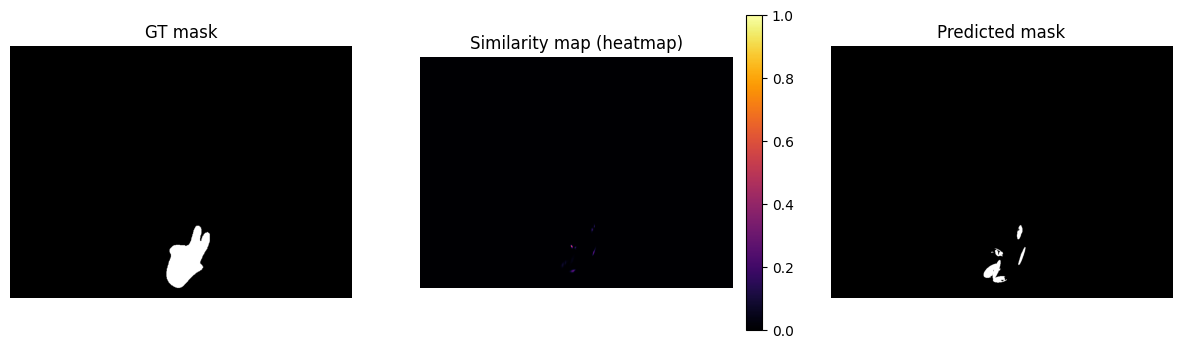

Frame 10: IoU = 0.221


In [399]:
import matplotlib.pyplot as plt

def visualize_frame(frame_idx, obj_id, mask_files, rendered_similarities_list, tau=0.0, normalize=True):
    mf = mask_files[frame_idx]
    sim_map = rendered_similarities_list[frame_idx]

    # GT mask 
    mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
    gt_mask = (mask_gt_img == obj_id).astype(np.uint8)

    # Predicted mask 
    if normalize:
        sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)
    pred_mask = (sim_map > tau).astype(np.uint8)

    #  Plot 
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("GT mask")
    plt.imshow(gt_mask, cmap="gray")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Similarity map (heatmap)")
    plt.imshow(sim_map, cmap="inferno")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.axis('off')

    plt.show()
    print(f"Frame {frame_idx}: IoU = {compute_iou(gt_mask, pred_mask):.3f}")

# Example: visualize frames 0, 5, 10
for idx in [0, 5, 10]:
    visualize_frame(idx, obj_id, mask_files=mask_files, rendered_similarities_list=rendered_similarities_list, tau=0.0)


# #TODO: RGB Metric evaluation - PSNR

In [400]:
import numpy as np
import torch
import cv2

# Selected frames to use 
selected_indices = list(range(16, 23)) + list(range(32, 45)) + list(range(105, 115))

def compute_psnr(gt_rgb, pred_rgb, mask=None):
    """
    Computes PSNR between GT and predicted RGB images.

    gt_rgb: HxWx3 uint8 array (ground truth)
    pred_rgb: HxWx3 uint8 array (prediction)
    mask: optional HxW binary array, only compute PSNR inside mask
    """
    gt = gt_rgb.astype(np.float32)
    pred = pred_rgb.astype(np.float32)
    
    if mask is not None:
        mask_flat = mask.astype(bool).flatten()
        gt = gt.reshape(-1, 3)[mask_flat]
        pred = pred.reshape(-1, 3)[mask_flat]
    
    mse = np.mean((gt - pred) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

def evaluate_object_psnr(obj_id, mask_files, rgb_files, cameras, scene_gaussians, pipeline, args, selected_indices):
    psnrs = []
    skipped, used = 0, 0

    # White background tensor
    FEATURE_DIM = scene_gaussians.get_features.shape[1]
    bg_color = [1.0 for _ in range(FEATURE_DIM)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    for frame_idx in selected_indices:
        mf = mask_files[frame_idx]
        rgb_f = rgb_files[frame_idx]
        cam = cameras[frame_idx]

        # GT mask 
        mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
        gt_mask = (mask_gt_img == obj_id).astype(np.uint8)
        
        if gt_mask.sum() == 0:
            print(f"Frame {frame_idx:03d}: object {obj_id} not visible → skipped")
            skipped += 1
            continue

        # GT RGB with white background 
        gt_full_rgb = cv2.imread(rgb_f)
        gt_rgb = np.ones_like(gt_full_rgb, dtype=np.uint8) * 255
        gt_rgb[gt_mask == 1] = gt_full_rgb[gt_mask == 1]

        # Render prediction with white background (GIF-style) 
        rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
        pred_rgb = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)

        # Compute PSNR only inside object
        psnr_val = compute_psnr(gt_rgb, pred_rgb, mask=gt_mask)
        psnrs.append(psnr_val)
        used += 1

        print(f"Frame {frame_idx:03d}: PSNR = {psnr_val:.2f} dB")

    print("\nSummary:")
    print(f"Frames used   : {used}")
    print(f"Frames skipped: {skipped}")
    if psnrs:
        print(f"Mean PSNR: {np.mean(psnrs):.2f} dB")
        print(f"Min PSNR : {np.min(psnrs):.2f} dB")
    
    return np.array(psnrs)

#  Usage
# obj_id = 49
psnrs = evaluate_object_psnr(
    obj_id=obj_id,
    mask_files=mask_files,
    rgb_files=rgb_files,
    cameras=all_cameras,  # make sure all_cameras is in same order as mask_files
    scene_gaussians=scene_gaussians,
    pipeline=pipeline,
    args=args,
    selected_indices=selected_indices
)


Frame 016: PSNR = 19.61 dB
Frame 017: PSNR = 18.57 dB
Frame 018: PSNR = 17.78 dB
Frame 019: PSNR = 16.66 dB
Frame 020: PSNR = 15.92 dB
Frame 021: PSNR = 15.30 dB
Frame 022: PSNR = 14.13 dB
Frame 032: PSNR = 14.72 dB
Frame 033: PSNR = 16.02 dB
Frame 034: PSNR = 16.32 dB
Frame 035: PSNR = 16.96 dB
Frame 036: PSNR = 17.44 dB
Frame 037: PSNR = 17.93 dB
Frame 038: PSNR = 17.20 dB
Frame 039: PSNR = 17.12 dB
Frame 040: PSNR = 17.24 dB
Frame 041: PSNR = 17.03 dB
Frame 042: PSNR = 16.53 dB
Frame 043: PSNR = 15.81 dB
Frame 044: PSNR = 15.03 dB
Frame 105: PSNR = 18.00 dB
Frame 106: PSNR = 20.39 dB
Frame 107: object 33 not visible → skipped
Frame 108: object 33 not visible → skipped
Frame 109: PSNR = 18.45 dB
Frame 110: PSNR = 18.68 dB
Frame 111: PSNR = 18.96 dB
Frame 112: PSNR = 13.18 dB
Frame 113: PSNR = 15.51 dB
Frame 114: PSNR = 15.55 dB

Summary:
Frames used   : 28
Frames skipped: 2
Mean PSNR: 16.86 dB
Min PSNR : 13.18 dB


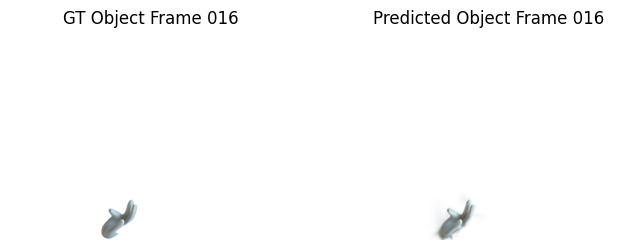

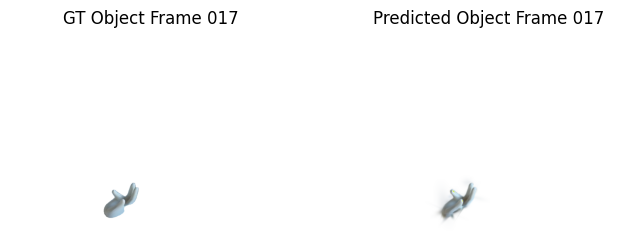

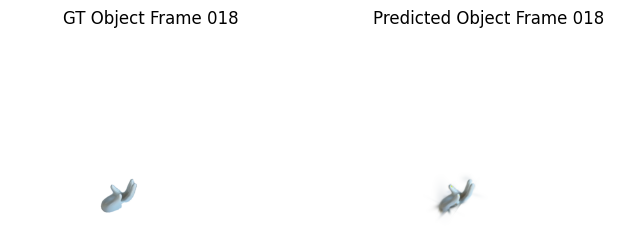

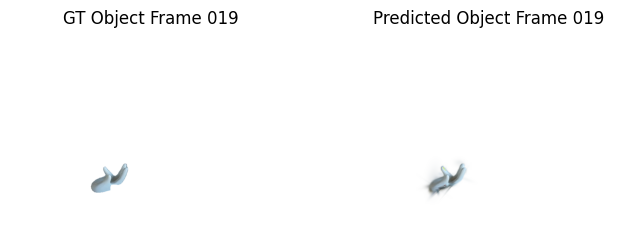

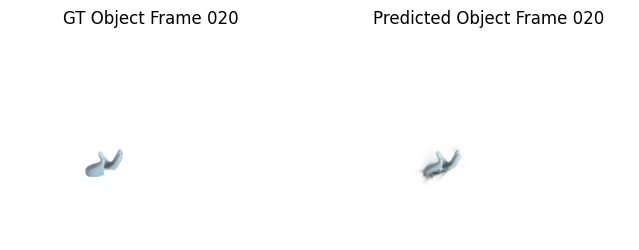

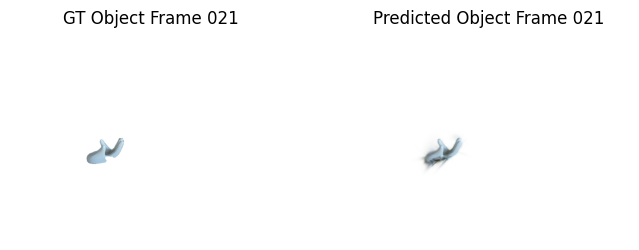

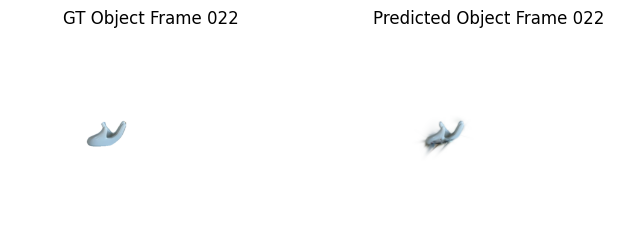

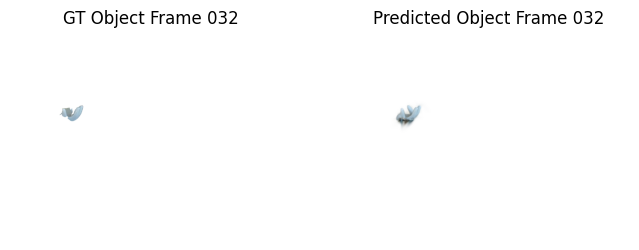

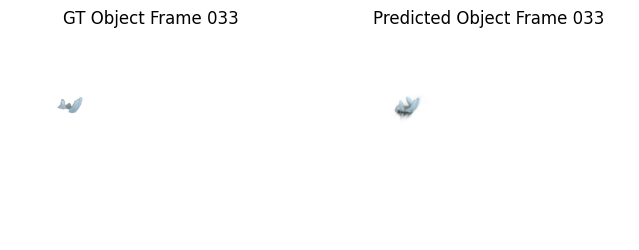

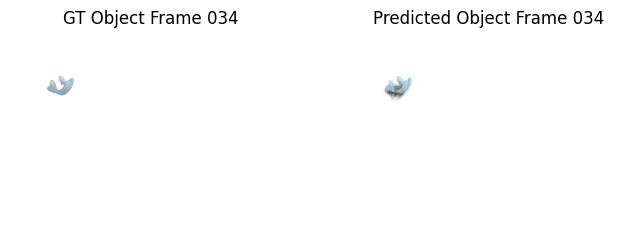

In [401]:
import matplotlib.pyplot as plt

def visualize_object_prediction(obj_id, mask_files, rgb_files, cameras, scene_gaussians, pipeline, args, selected_indices, n_frames=5):
    """
    Displays GT object (on white background) and predicted RGB object side by side.
    Uses the same rendering setup as PSNR evaluation (white background).
    """
    # White background tensor (RGB)
    bg_color = [1.0, 1.0, 1.0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    shown = 0
    for frame_idx in selected_indices:
        if shown >= n_frames:
            break

        mf = mask_files[frame_idx]
        rgb_f = rgb_files[frame_idx]
        cam = cameras[frame_idx]

        # --- GT mask ---
        mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
        gt_mask = (mask_gt_img == obj_id).astype(np.uint8)

        if gt_mask.sum() == 0:
            print(f"Frame {frame_idx:03d}: object {obj_id} not visible → skipped")
            continue

        # --- GT RGB object on white background ---
        gt_full_rgb = cv2.imread(rgb_f)
        gt_rgb = np.ones_like(gt_full_rgb, dtype=np.uint8) * 255
        gt_rgb[gt_mask == 1] = gt_full_rgb[gt_mask == 1]

        # --- Predicted RGB (white background) ---
        rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
        pred_rgb = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)

        # --- Plot side by side ---
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(gt_rgb, cv2.COLOR_BGR2RGB))
        plt.title(f'GT Object Frame {frame_idx:03d}')
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(pred_rgb)
        plt.title(f'Predicted Object Frame {frame_idx:03d}')
        plt.axis('off')

        plt.show()

        shown += 1


# Example usage
visualize_object_prediction(
    obj_id,
    mask_files=mask_files,
    rgb_files=rgb_files,
    cameras=all_cameras,
    scene_gaussians=scene_gaussians,
    pipeline=pipeline,
    args=args,
    selected_indices=selected_indices,
    n_frames=10
)


# NEW : Removing artifacts

Create copy of scene for more efficient tuning of artifact removal parameters, without having to restart notebook

In [29]:
import copy

# Make a deep copy of the original scene before any artifact removal
if "scene_gaussians_backup" not in globals():
    scene_gaussians_backup = copy.deepcopy(scene_gaussians)
    print("Backup of scene_gaussians created")
else:
    print("Backup already exists, not overwritten")


Backup of scene_gaussians created


Run this cell after tuning parameters in artifact removal:

In [403]:
# # Restore the original unmodified scene
# scene_gaussians = copy.deepcopy(scene_gaussians_backup)
# print("scene_gaussians restored from backup")


this first one works on most objects, the alternatives below either dont run or they completely erase the object or scattered points

In [30]:
import open3d as o3d
import numpy as np
import torch

#eps, min_points and N can be tuned
# Step 1: extract gaussian centers (as Nx3 numpy array)
xyz = scene_gaussians.get_xyz.detach().cpu().numpy()

# Step 2: build an open3d point cloud for clustering
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)

# # Step 3: Connected components via DBSCAN
# labels = np.array(pcd.cluster_dbscan(eps=0.02, min_points=20, print_progress=False))
# largest_label = np.bincount(labels[labels >= 0]).argmax()  # ignore noise (-1)
# mask_keep = labels == largest_label

###
# Step 3: Connected components ? via DBSCAN (larger eps, looser clustering)
labels = np.array(pcd.cluster_dbscan(eps=0.08, min_points=20, print_progress=False)) #################### IMPORTANT PARAMETERS default eps = 0.08 min_points = 20

# Count cluster sizes (ignore noise label -1)
valid_labels = labels[labels >= 0]
counts = np.bincount(valid_labels)

# Keep top N largest clusters
N = 1  # keep biggest 3 blobs ########################################### IMPORTANT PARAMETERS
largest_labels = np.argsort(-counts)[:N]  # sort by size descending
mask_keep = np.isin(labels, largest_labels)

# Step 4: Apply mask to all Gaussian attributes
attrs = ["_xyz", "_features_dc", "_features_rest", "_scaling", "_rotation", "_opacity"]
for attr in attrs:
    setattr(scene_gaussians, attr, getattr(scene_gaussians, attr)[mask_keep])

# scene_gaussians._xyz = scene_gaussians._xyz[mask_keep]
# scene_gaussians._features_dc = scene_gaussians._features_dc[mask_keep]
# scene_gaussians._features_rest = scene_gaussians._features_rest[mask_keep]
# scene_gaussians._scaling = scene_gaussians._scaling[mask_keep]
# scene_gaussians._rotation = scene_gaussians._rotation[mask_keep]
# scene_gaussians._opacity = scene_gaussians._opacity[mask_keep]


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Alternative not density based:

In [405]:
# import torch
# import numpy as np
# import open3d as o3d

# # --- 0) Settings ---
# SIM_THR = 0.5          # similarity threshold to select object Gaussians
# DBSCAN_EPS = 0.08       # clustering radius
# DBSCAN_MIN_POINTS = 10  # min points per cluster
# DO_PRUNE = True         # prune opacity / scale outliers
# PRUNE_OPACITY_PERCENTILE = 5
# PRUNE_SCALE_PERCENTILE = 97

# # --- 1) Compute similarity aligned to scene_gaussians ---
# # Make sure feature_gaussians and scene_gaussians are aligned in size
# scene_features = feature_gaussians.get_point_features[:scene_gaussians._xyz.shape[0]]
# scene_features = torch.nn.functional.normalize(scene_features, dim=-1)
# query_feature = query_feature.cuda()  # ensure same device

# similarities_scene = torch.einsum('C,NC->N', query_feature, scene_features)

# # --- 2) Build segmentation mask ---
# seg_mask = (similarities_scene > SIM_THR)  # shape exactly matches scene_gaussians._xyz
# seg_mask = seg_mask.to(torch.bool)

# if seg_mask.sum() == 0:
#     raise RuntimeError(f"No Gaussians selected with SIM_THR={SIM_THR}!")

# print(f"[Cleanup] Initially selected Gaussians: {seg_mask.sum().item()} / {len(seg_mask)}")

# # --- 3) Extract xyz for DBSCAN ---
# xyz_sel = scene_gaussians._xyz[seg_mask].detach().cpu().numpy()
# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(xyz_sel)

# # --- 4) DBSCAN to remove floating Gaussians ---
# labels = np.array(pcd.cluster_dbscan(eps=DBSCAN_EPS, min_points=DBSCAN_MIN_POINTS, print_progress=False))
# valid_labels = labels[labels >= 0]

# if len(valid_labels) == 0:
#     print("[Cleanup] Warning: all points labeled as noise; keeping original segmentation")
#     keep_local = np.ones(len(xyz_sel), dtype=bool)
# else:
#     largest_label = np.bincount(valid_labels).argmax()
#     keep_local = (labels == largest_label)

# # --- 5) Map local DBSCAN mask back to global mask ---
# keep_global = torch.zeros_like(seg_mask)
# keep_global[seg_mask] = torch.from_numpy(keep_local).to(seg_mask.device)

# print(f"[Cleanup] Gaussians kept after DBSCAN: {keep_global.sum().item()} / {len(keep_global)}")

# # --- 6) Optional pruning by opacity / scale ---
# if DO_PRUNE:
#     kept_idx = torch.where(keep_global)[0]
#     if len(kept_idx) > 20:
#         # Opacity pruning
#         opac = scene_gaussians._opacity.detach().cpu().numpy().reshape(-1)
#         lo = np.percentile(opac[kept_idx.cpu().numpy()], PRUNE_OPACITY_PERCENTILE)
#         keep_global &= (torch.from_numpy(opac).to(keep_global.device) >= lo)

#         # Scale pruning
#         try:
#             scales = scene_gaussians._scaling.detach().cpu().numpy().reshape(len(seg_mask), -1)
#             s_norm = np.linalg.norm(scales, axis=1)
#             hi = np.percentile(s_norm[kept_idx.cpu().numpy()], PRUNE_SCALE_PERCENTILE)
#             keep_global &= (torch.from_numpy(s_norm).to(keep_global.device) <= hi)
#         except Exception:
#             pass

# print(f"[Cleanup] Gaussians kept after pruning: {keep_global.sum().item()} / {len(keep_global)}")

# # --- 7) Apply mask to scene_gaussians ---
# attrs = ["_xyz", "_features_dc", "_features_rest", "_scaling", "_rotation", "_opacity"]
# for attr in attrs:
#     tensor = getattr(scene_gaussians, attr)
#     setattr(scene_gaussians, attr, tensor[keep_global])

# print(f"[Cleanup] Final Gaussians ready for rendering: {scene_gaussians._xyz.shape[0]}")


[OPTIONAL] cell for more additional refinement if needed. but normally it will erase the object in most cases:

In [406]:
# #  Segmentation-aware connected components cleanup (aligned similarities) 

# import numpy as np
# import torch
# from sklearn.neighbors import NearestNeighbors
# from scipy.sparse.csgraph import connected_components
# from scipy.sparse import coo_matrix

# # 0) Inputs we already have from your notebook:
# # - similarities: (N,) cosine similarity to query_feature for each Gaussian
# # - scene_gaussians: holds _xyz, _opacity, _scaling, etc.

# # --- ALIGN similarities with current Gaussians ---
# xyz_all = scene_gaussians.get_xyz.detach().cpu().numpy()
# if similarities.shape[0] != xyz_all.shape[0]:
#     print(f"[Info] similarities ({similarities.shape[0]}) != Gaussians ({xyz_all.shape[0]}). Aligning to current Gaussians.")
#     sim = similarities[:xyz_all.shape[0]].detach().cpu()
# else:
#     sim = similarities.detach().cpu()

# # 1) Restrict to the segmented set first
# SIM_THR = 0.01  # same threshold used for scene_gaussians.segment(...).    ############# IMPORTANT PARAMETERS default =  0.01
# selected_idx = torch.where(sim > SIM_THR)[0]
# if selected_idx.numel() == 0:
#     raise RuntimeError("No Gaussians passed the similarity threshold; try lowering SIM_THR.")

# xyz_sel = xyz_all[selected_idx.numpy()]

# # 2) Build an adaptive-radius graph on the selected points only
# K_FOR_STATS = 10
# nbrs_stats = NearestNeighbors(n_neighbors=min(K_FOR_STATS, max(2, len(xyz_sel) - 1)) ).fit(xyz_sel)
# dists, inds = nbrs_stats.kneighbors(xyz_sel)
# k_pick = min(5, dists.shape[1]-1)
# base_r = np.median(dists[:, k_pick])
# RADIUS = float(max(1e-6, 1.5 * base_r))  # slightly looser than median local spacing

# nbrs = NearestNeighbors(radius=RADIUS).fit(xyz_sel)
# radius_graph = nbrs.radius_neighbors_graph(xyz_sel, mode='connectivity')

# # Optional: feature-based edge pruning to break bridges
# # feat_sel = normed_scale_conditioned_point_features[selected_idx].detach().cpu().numpy()
# # rows, cols = radius_graph.nonzero()
# # pair_ok = (np.einsum('nc,nc->n', feat_sel[rows], feat_sel[cols]) > 0.6)
# # radius_graph = coo_matrix((pair_ok.astype(np.float32), (rows, cols)), shape=radius_graph.shape)

# # 3) Connected components on the selected set
# n_cc, labels_sel = connected_components(csgraph=radius_graph, directed=False)
# labels_sel = labels_sel.astype(np.int32)
# print(f"[Cleanup] Selected={len(xyz_sel)}, components={n_cc}, radius={RADIUS:.5f}")

# # 4) Choose the single best component (highest mean similarity)
# sim_sel = sim[selected_idx].numpy()
# comp_means = np.array([sim_sel[labels_sel == k].mean() for k in range(n_cc)])
# best_cc = int(comp_means.argmax())
# keep_sel_mask = (labels_sel == best_cc)

# # 5) Optional dilation to recover thin parts.    #### IMPORTANT (SECONDARY) PARAMETERS
# DO_DILATE = True
# if DO_DILATE:
#     DILATE_RADIUS = 1.25 * RADIUS
#     core_xyz = xyz_sel[keep_sel_mask]
#     all_nbrs = NearestNeighbors(radius=DILATE_RADIUS).fit(core_xyz)
#     A = all_nbrs.radius_neighbors_graph(xyz_all, mode='connectivity')
#     touched = np.asarray(A.sum(axis=1)).ravel() > 0
#     MIN_SIM_EXPAND = 0.30
#     expand_mask = (sim.detach().cpu().numpy() > MIN_SIM_EXPAND) & touched
# else:
#     expand_mask = np.zeros(len(xyz_all), dtype=bool)

# # 6) Final keep mask in global indexing
# keep_global = np.zeros(len(xyz_all), dtype=bool)
# keep_global[selected_idx.numpy()] = keep_sel_mask
# keep_global |= expand_mask

# # 7) Optional light pruning by opacity/scale outliers  #### IMPORTANT (SECONDARY) PARAMETERS
# DO_PRUNE = True
# if DO_PRUNE:
#     kept_idx = np.where(keep_global)[0]
#     if len(kept_idx) > 20:
#         # Prune low-opacity
#         opac = scene_gaussians.get_opacity.detach().cpu().numpy().reshape(-1)
#         op_kept = opac[kept_idx]
#         lo = np.percentile(op_kept, 5)
#         keep_global &= (opac >= lo)

#         # Prune extreme scales
#         try:
#             scales = scene_gaussians.get_scaling.detach().cpu().numpy().reshape(len(xyz_all), -1)
#             s_norm = np.linalg.norm(scales, axis=1)
#             s_kept = s_norm[kept_idx]
#             hi = np.percentile(s_kept, 97)
#             keep_global &= (s_norm <= hi)
#         except Exception:
#             pass

# # 8) Apply the mask to all Gaussian tensors
# attrs = ["_xyz", "_features_dc", "_features_rest", "_scaling", "_rotation", "_opacity"]
# mask_keep_torch = torch.from_numpy(keep_global).to(scene_gaussians._xyz.device)
# for attr in attrs:
#     tensor = getattr(scene_gaussians, attr)
#     setattr(scene_gaussians, attr, tensor[mask_keep_torch])

# # 9) Skip alignment for feature_gaussians if shapes mismatch
# if hasattr(feature_gaussians, "_point_features"):
#     if feature_gaussians._point_features.shape[0] == scene_gaussians._xyz.shape[0]:
#         feature_gaussians._point_features = feature_gaussians._point_features[mask_keep_torch]
# elif hasattr(feature_gaussians, "point_features"):
#     if feature_gaussians.point_features.shape[0] == scene_gaussians._xyz.shape[0]:
#         feature_gaussians.point_features = feature_gaussians.point_features[mask_keep_torch]



Potential alternative and more robust solutions, had index errors in the beginning

In [407]:
# # --- RUN THIS RIGHT AFTER YOU COMPUTE `similarities` AND BEFORE ANY RENDER/SEGMENT ---

# import numpy as np
# import torch
# import open3d as o3d

# # 0) Safety: ensure we haven’t already shrunk scene_gaussians
# # (If you already called scene_gaussians.segment(...), re-run from the cell that defines scene/gaussians.)

# # 1) Use *feature* gaussians for clustering (same indexing as `similarities`)
# if hasattr(feature_gaussians, "get_xyz"):
#     feat_xyz = feature_gaussians.get_xyz.detach().cpu().numpy()
# else:
#     feat_xyz = feature_gaussians._xyz.detach().cpu().numpy()

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(feat_xyz)

# # 2) Cluster
# # Tweak eps/min_points if it’s too aggressive (start with eps in [0.02, 0.05], min_points 10–50)
# labels = np.array(pcd.cluster_dbscan(eps=0.03, min_points=20, print_progress=False))

# # 3) Build segmentation indices from your similarity mask
# segmentation_mask = (similarities.detach().cpu().numpy() > 0.75)
# selected_idx = np.where(segmentation_mask)[0]

# if selected_idx.size == 0:
#     print("⚠️ No points passed the similarity threshold; skipping filtering.")
#     mask_keep_feat = np.ones(len(labels), dtype=bool)
# else:
#     # Choose the cluster that covers MOST of your segmented points (majority vote)
#     sel_labels = labels[selected_idx]
#     sel_labels = sel_labels[sel_labels >= 0]  # drop DBSCAN noise
#     if sel_labels.size == 0:
#         print("⚠️ All selected points were labeled as noise by DBSCAN; fall back to the raw segmentation mask.")
#         mask_keep_feat = segmentation_mask
#     else:
#         object_cluster = np.bincount(sel_labels).argmax()
#         mask_keep_feat = (labels == object_cluster)

# # Optional: union with your segmentation to keep borderline points
# mask_keep_feat = np.logical_or(mask_keep_feat, segmentation_mask)

# print(f"[Feature] keep {mask_keep_feat.sum()} / {len(mask_keep_feat)} points")

# # 4) Map mask to scene gaussians if counts differ
# if hasattr(scene_gaussians, "get_xyz"):
#     scene_xyz = scene_gaussians.get_xyz.detach().cpu()
# else:
#     scene_xyz = scene_gaussians._xyz.detach().cpu()

# same_count = (scene_xyz.shape[0] == mask_keep_feat.shape[0])

# if same_count:
#     mask_keep_scene = mask_keep_feat
# else:
#     # Map each SCENE point to nearest FEATURE point, then inherit its keep flag
#     import pytorch3d.ops as p3d_ops
#     feat_xyz_t = torch.from_numpy(feat_xyz).float()
#     idx = p3d_ops.knn_points(scene_xyz[None].float(), feat_xyz_t[None], K=1).idx.squeeze(0).squeeze(-1)  # [Ns]
#     mask_keep_scene = torch.from_numpy(mask_keep_feat)[idx].cpu().numpy()
#     print(f"[Map] scene N={scene_xyz.shape[0]}  feature N={feat_xyz.shape[0]}  (mapped by 1-NN)")

# print(f"[Scene] keep {mask_keep_scene.sum()} / {mask_keep_scene.size} points")

# # 5) Apply masks to BOTH models (keep order!)
# def apply_mask_to_gaussians(G, mask_np):
#     m = torch.from_numpy(mask_np).to(G._xyz.device)
#     G._xyz = G._xyz[m]
#     G._features_dc = G._features_dc[m]
#     G._features_rest = G._features_rest[m]
#     G._scaling = G._scaling[m]
#     G._rotation = G._rotation[m]
#     G._opacity = G._opacity[m]

# # Feature model
# apply_mask_to_gaussians(feature_gaussians, mask_keep_feat)
# # Scene model
# apply_mask_to_gaussians(scene_gaussians, mask_keep_scene)

# print("✅ Applied connected-components filtering (cluster ∪ segmentation). Proceed to render.")


# #TODO: Metrics computation after artifact removal

In [408]:

# Build rendered similarities list for ALL frames (not just selected)
rendered_similarities_clean = []
for idx, (mf, cam) in enumerate(zip(mask_files, all_cameras)):
    out = render(
        cam,
        scene_gaussians,  # cleaned Gaussians
        pipeline.extract(args),
        background,
        override_color=similarities.unsqueeze(-1).repeat([1, 3])
    )
    sim_map = out['render']  # [3,H,W]
    sim_map = sim_map.permute(1, 2, 0)[:, :, 0]  # take first channel
    sim_map = sim_map.detach().cpu().numpy()
    rendered_similarities_clean.append(sim_map)

print(f"Built rendered_similarities_clean with {len(rendered_similarities_clean)} frames")

# Now evaluate on the SAME selected_indices as before
# obj_id = 49
ious_clean = evaluate_object_iou(
    obj_id=obj_id,
    mask_files=mask_files,
    rendered_similarities_list=rendered_similarities_clean,
    tau=0.0,
    selected_indices=selected_indices
)


Built rendered_similarities_clean with 299 frames
Frame 016: IoU = 0.358
Frame 017: IoU = 0.301
Frame 018: IoU = 0.283
Frame 019: IoU = 0.257
Frame 020: IoU = 0.236
Frame 021: IoU = 0.237
Frame 022: IoU = 0.204
Frame 032: IoU = 0.244
Frame 033: IoU = 0.241
Frame 034: IoU = 0.292
Frame 035: IoU = 0.298
Frame 036: IoU = 0.283
Frame 037: IoU = 0.321
Frame 038: IoU = 0.334
Frame 039: IoU = 0.319
Frame 040: IoU = 0.306
Frame 041: IoU = 0.290
Frame 042: IoU = 0.254
Frame 043: IoU = 0.214
Frame 044: IoU = 0.224
Frame 105: IoU = 0.301
Frame 106: IoU = 0.156
Frame 107: object 33 not visible --> skipped
Frame 108: object 33 not visible --> skipped
Frame 109: IoU = 0.166
Frame 110: IoU = 0.176
Frame 111: IoU = 0.166
Frame 112: IoU = 0.146
Frame 113: IoU = 0.163
Frame 114: IoU = 0.228

Summary:
Frames used   : 28
Frames skipped: 2
Mean IoU: 0.250
Min IoU : 0.146


visualization:

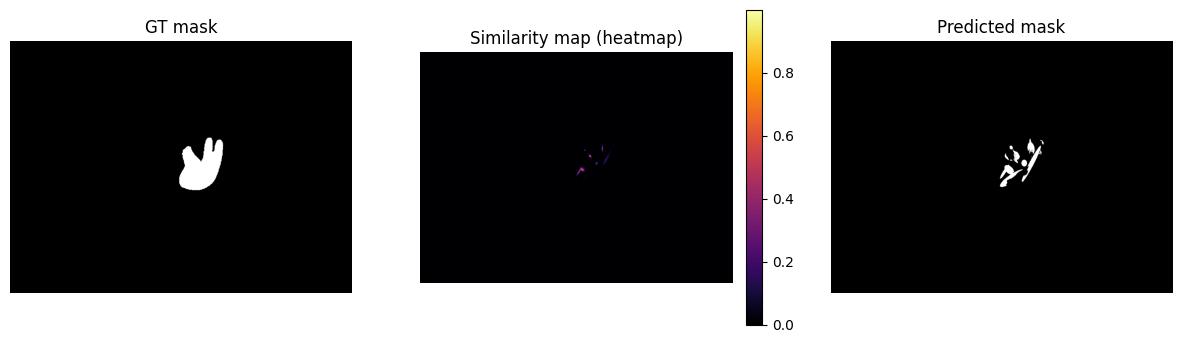

Frame 0: IoU = 0.283


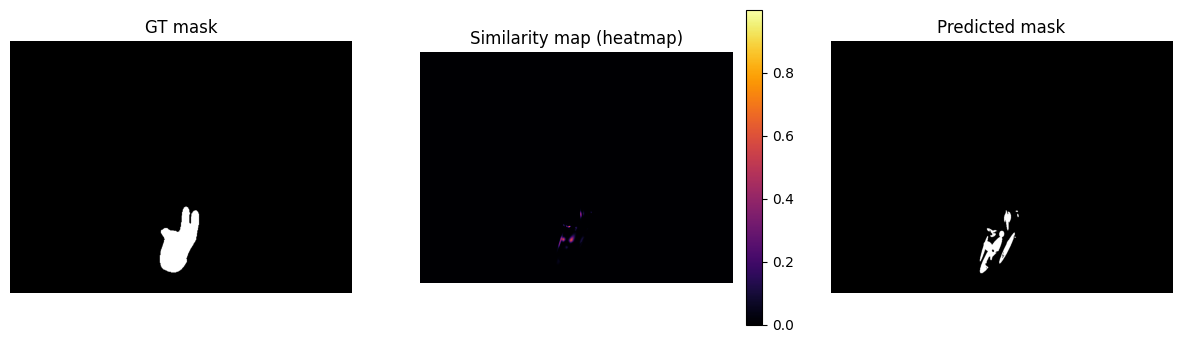

Frame 5: IoU = 0.364


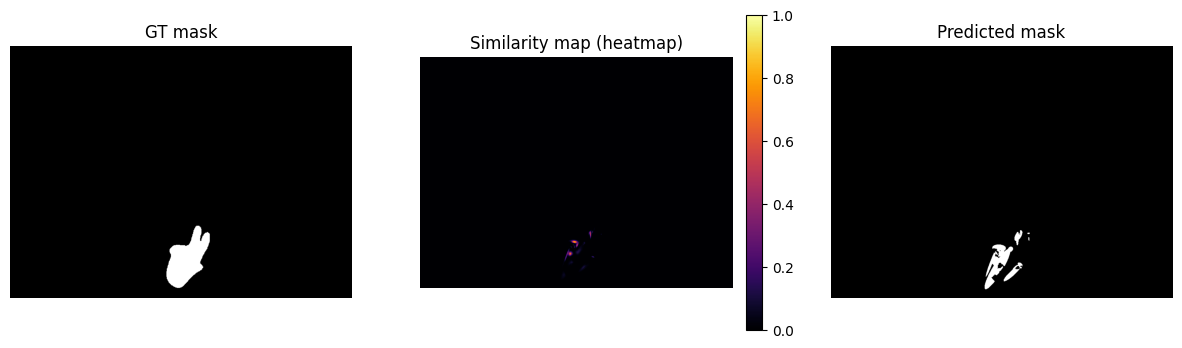

Frame 10: IoU = 0.388


In [409]:
import matplotlib.pyplot as plt

def visualize_frame(frame_idx, obj_id, mask_files, rendered_similarities_list, tau=0.0, normalize=True):
    mf = mask_files[frame_idx]
    sim_map = rendered_similarities_list[frame_idx]

    # GT mask 
    mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
    gt_mask = (mask_gt_img == obj_id).astype(np.uint8)

    # Predicted mask 
    if normalize:
        sim_map = (sim_map - sim_map.min()) / (sim_map.max() - sim_map.min() + 1e-8)
    pred_mask = (sim_map > tau).astype(np.uint8)

    #  Plot 
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.title("GT mask")
    plt.imshow(gt_mask, cmap="gray")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.title("Similarity map (heatmap)")
    plt.imshow(sim_map, cmap="inferno")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.title("Predicted mask")
    plt.imshow(pred_mask, cmap="gray")
    plt.axis('off')

    plt.show()
    print(f"Frame {frame_idx}: IoU = {compute_iou(gt_mask, pred_mask):.3f}")

# Example: visualize frames 0, 5, 10
for idx in [0, 5, 10]:
    visualize_frame(idx, obj_id, mask_files=mask_files, rendered_similarities_list=rendered_similarities_clean, tau=0.0)


PSNR:

In [410]:
import numpy as np
import torch
import cv2

# --- Selected frames to use ---
selected_indices = list(range(16, 23)) + list(range(32, 45)) + list(range(105, 115))

def compute_psnr(gt_rgb, pred_rgb, mask=None):
    """
    Computes PSNR between GT and predicted RGB images.

    gt_rgb: HxWx3 uint8 array (ground truth)
    pred_rgb: HxWx3 uint8 array (prediction)
    mask: optional HxW binary array, only compute PSNR inside mask
    """
    gt = gt_rgb.astype(np.float32)
    pred = pred_rgb.astype(np.float32)
    
    if mask is not None:
        mask_flat = mask.astype(bool).flatten()
        gt = gt.reshape(-1, 3)[mask_flat]
        pred = pred.reshape(-1, 3)[mask_flat]
    
    mse = np.mean((gt - pred) ** 2)
    if mse == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr

def evaluate_object_psnr_after_artifact_removal(
    obj_id, mask_files, rgb_files, cameras, scene_gaussians, pipeline, args, selected_indices
):
    psnrs = []
    skipped, used = 0, 0

    # White background tensor (must match "before" version) 
    FEATURE_DIM = scene_gaussians.get_features.shape[1]
    bg_color = [1.0 for _ in range(FEATURE_DIM)]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    for frame_idx in selected_indices:
        mf = mask_files[frame_idx]
        rgb_f = rgb_files[frame_idx]
        cam = cameras[frame_idx]

        # GT mask 
        mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
        gt_mask = (mask_gt_img == obj_id).astype(np.uint8)
        if gt_mask.sum() == 0:
            print(f"Frame {frame_idx:03d}: object {obj_id} not visible → skipped")
            skipped += 1
            continue

        #  GT RGB on white background 
        gt_full_rgb = cv2.imread(rgb_f)
        gt_rgb = np.ones_like(gt_full_rgb, dtype=np.uint8) * 255
        gt_rgb[gt_mask == 1] = gt_full_rgb[gt_mask == 1]

        # Render cleaned Gaussians (white background) 
        rendered = render(
            cam,
            scene_gaussians,  # cleaned Gaussians
            pipeline.extract(args),
            background
        )['render']  # [C,H,W]

        #  Convert to HxWx3 uint8 [0,255] 
        pred_rgb = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
        if pred_rgb.shape[2] == 1:  # unlikely, but just in case
            pred_rgb = np.repeat(pred_rgb, 3, axis=2)

        #  Compute PSNR only inside object mask 
        psnr_val = compute_psnr(gt_rgb, pred_rgb, mask=gt_mask)
        psnrs.append(psnr_val)
        used += 1

        print(f"Frame {frame_idx:03d}: PSNR = {psnr_val:.2f} dB")

    print("\nSummary:")
    print(f"Frames used   : {used}")
    print(f"Frames skipped: {skipped}")
    if psnrs:
        print(f"Mean PSNR: {np.mean(psnrs):.2f} dB")
        print(f"Min PSNR : {np.min(psnrs):.2f} dB")

    return np.array(psnrs)


# --- Usage after artifact removal ---
# obj_id = 49
psnrs_clean = evaluate_object_psnr_after_artifact_removal(
    obj_id=obj_id,
    mask_files=mask_files,
    rgb_files=rgb_files,
    cameras=all_cameras,
    scene_gaussians=scene_gaussians,
    pipeline=pipeline,
    args=args,
    selected_indices=selected_indices
)


Frame 016: PSNR = 19.60 dB
Frame 017: PSNR = 18.55 dB
Frame 018: PSNR = 17.75 dB
Frame 019: PSNR = 16.64 dB
Frame 020: PSNR = 15.91 dB
Frame 021: PSNR = 15.29 dB
Frame 022: PSNR = 14.12 dB
Frame 032: PSNR = 14.72 dB
Frame 033: PSNR = 16.02 dB
Frame 034: PSNR = 16.32 dB
Frame 035: PSNR = 16.96 dB
Frame 036: PSNR = 17.45 dB
Frame 037: PSNR = 17.93 dB
Frame 038: PSNR = 17.19 dB
Frame 039: PSNR = 17.10 dB
Frame 040: PSNR = 17.24 dB
Frame 041: PSNR = 17.03 dB
Frame 042: PSNR = 16.53 dB
Frame 043: PSNR = 15.81 dB
Frame 044: PSNR = 15.03 dB
Frame 105: PSNR = 18.00 dB
Frame 106: PSNR = 20.39 dB
Frame 107: object 33 not visible → skipped
Frame 108: object 33 not visible → skipped
Frame 109: PSNR = 18.45 dB
Frame 110: PSNR = 18.66 dB
Frame 111: PSNR = 18.93 dB
Frame 112: PSNR = 13.18 dB
Frame 113: PSNR = 15.51 dB
Frame 114: PSNR = 15.54 dB

Summary:
Frames used   : 28
Frames skipped: 2
Mean PSNR: 16.85 dB
Min PSNR : 13.18 dB


Visualization:

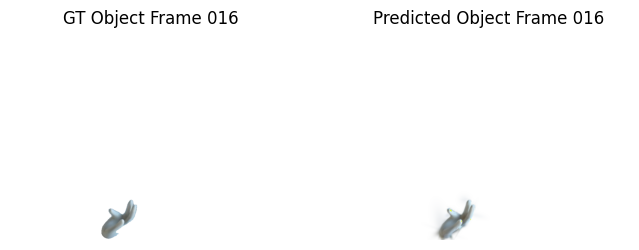

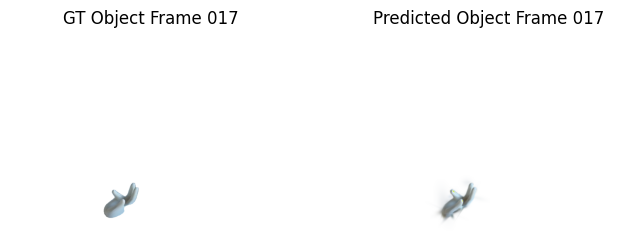

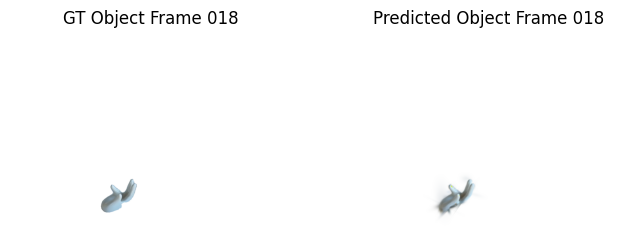

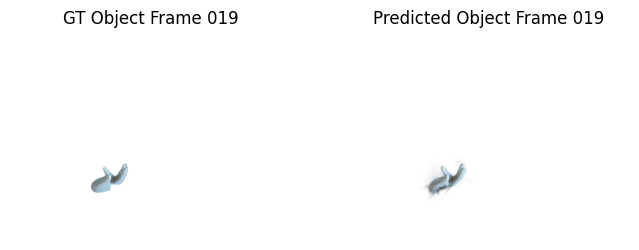

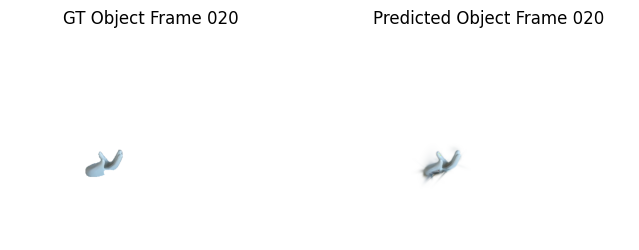

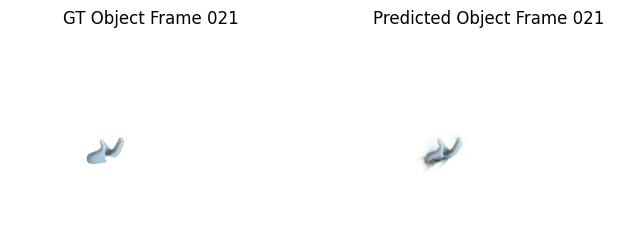

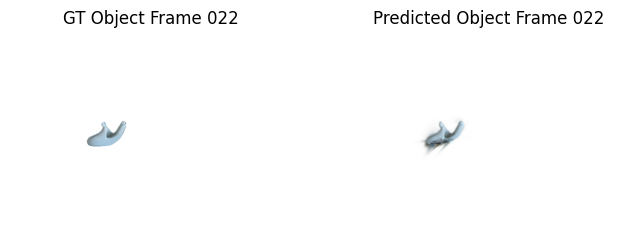

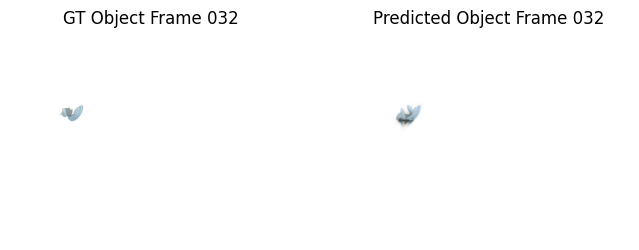

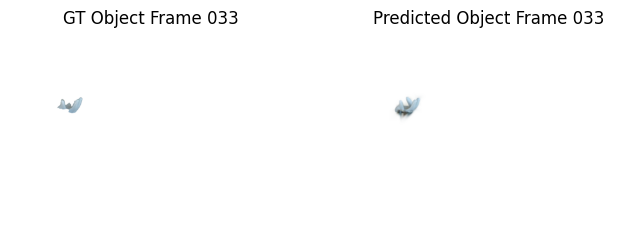

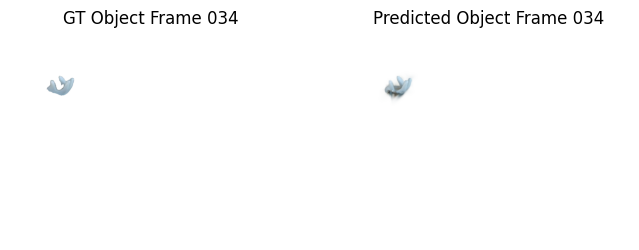

In [411]:
import matplotlib.pyplot as plt

def visualize_object_prediction(obj_id, mask_files, rgb_files, cameras, scene_gaussians, pipeline, args, selected_indices, n_frames=5):
    """
    Displays GT object (on white background) and predicted RGB object side by side.
    Uses the same rendering setup as PSNR evaluation (white background).
    """
    # White background tensor (RGB)
    bg_color = [1.0, 1.0, 1.0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    shown = 0
    for frame_idx in selected_indices:
        if shown >= n_frames:
            break

        mf = mask_files[frame_idx]
        rgb_f = rgb_files[frame_idx]
        cam = cameras[frame_idx]

        # --- GT mask ---
        mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
        gt_mask = (mask_gt_img == obj_id).astype(np.uint8)

        if gt_mask.sum() == 0:
            print(f"Frame {frame_idx:03d}: object {obj_id} not visible → skipped")
            continue

        # --- GT RGB object on white background ---
        gt_full_rgb = cv2.imread(rgb_f)
        gt_rgb = np.ones_like(gt_full_rgb, dtype=np.uint8) * 255
        gt_rgb[gt_mask == 1] = gt_full_rgb[gt_mask == 1]

        # --- Predicted RGB (white background) ---
        rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
        pred_rgb = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)

        # --- Plot side by side ---
        plt.figure(figsize=(8,4))
        plt.subplot(1,2,1)
        plt.imshow(cv2.cvtColor(gt_rgb, cv2.COLOR_BGR2RGB))
        plt.title(f'GT Object Frame {frame_idx:03d}')
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.imshow(pred_rgb)
        plt.title(f'Predicted Object Frame {frame_idx:03d}')
        plt.axis('off')

        plt.show()

        shown += 1


# Example usage
visualize_object_prediction(
    obj_id,
    mask_files=mask_files,
    rgb_files=rgb_files,
    cameras=all_cameras,
    scene_gaussians=scene_gaussians,
    pipeline=pipeline,
    args=args,
    selected_indices=selected_indices,
    n_frames=10
)


In [412]:
# import numpy as np
# import cv2
# from skimage.metrics import structural_similarity as ssim
# import torch

# # --- Compute SSIM inside mask ---
# def compute_ssim(gt_rgb, pred_rgb, mask=None):
#     """
#     Computes SSIM between GT and predicted RGB images.
#     gt_rgb, pred_rgb: HxWx3 uint8
#     mask: HxW binary mask
#     """
#     gt = gt_rgb.astype(np.float32) / 255.0
#     pred = pred_rgb.astype(np.float32) / 255.0

#     if mask is not None:
#         mask_flat = mask.astype(bool)
#         ssim_val = 0
#         for c in range(3):  # compute SSIM per channel
#             ssim_val += ssim(gt[:,:,c], pred[:,:,c], data_range=1.0, gaussian_weights=True, full=False, win_size=11, multichannel=False, mask=mask_flat)
#         ssim_val /= 3.0
#         return ssim_val
#     else:
#         ssim_val = 0
#         for c in range(3):
#             ssim_val += ssim(gt[:,:,c], pred[:,:,c], data_range=1.0, gaussian_weights=True, full=False, win_size=11, multichannel=False)
#         ssim_val /= 3.0
#         return ssim_val


# # --- Evaluate SSIM for selected frames ---
# def evaluate_object_ssim(obj_id, mask_files, rgb_files, cameras, scene_gaussians, pipeline, args, selected_indices):
#     ssims = []
#     skipped = 0

#     # White background tensor
#     FEATURE_DIM = scene_gaussians.get_features.shape[1]
#     bg_color = [1.0 for _ in range(FEATURE_DIM)]
#     background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

#     for frame_idx in selected_indices:
#         mf = mask_files[frame_idx]
#         rgb_f = rgb_files[frame_idx]
#         cam = cameras[frame_idx]

#         # --- GT mask ---
#         mask_gt_img = cv2.imread(mf, cv2.IMREAD_UNCHANGED)
#         gt_mask = (mask_gt_img == obj_id).astype(np.uint8)
#         if gt_mask.sum() == 0:
#             skipped += 1
#             continue

#         # --- GT RGB on white background ---
#         gt_full_rgb = cv2.imread(rgb_f)
#         gt_rgb = np.ones_like(gt_full_rgb, dtype=np.uint8) * 255
#         gt_rgb[gt_mask == 1] = gt_full_rgb[gt_mask == 1]

#         # --- Predicted RGB ---
#         rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
#         pred_rgb = (rendered.permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
#         if pred_rgb.shape[2] == 1:
#             pred_rgb = np.repeat(pred_rgb, 3, axis=2)

#         # --- Compute SSIM only inside object mask ---
#         ssim_val = compute_ssim(gt_rgb, pred_rgb, mask=gt_mask)
#         ssims.append(ssim_val)
#         print(f"Frame {frame_idx:03d}: SSIM = {ssim_val:.3f}")

#     print(f"\nFrames used: {len(selected_indices) - skipped}, skipped: {skipped}")
#     print(f"Mean SSIM: {np.mean(ssims):.3f}, Min SSIM: {np.min(ssims):.3f}")
#     return np.array(ssims)


# # --- Usage example ---
# # obj_id = 70
# ssims_clean = evaluate_object_ssim(
#     obj_id=obj_id,
#     mask_files=mask_files,
#     rgb_files=rgb_files,
#     cameras=all_cameras,
#     scene_gaussians=scene_gaussians,
#     pipeline=pipeline,
#     args=args,
#     selected_indices=selected_indices
# )


# Render segmented object:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.010526946..1.0053886].


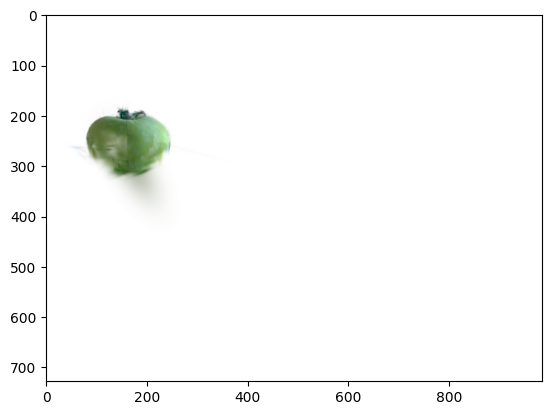

In [34]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[1], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0013704821..1.3426323].


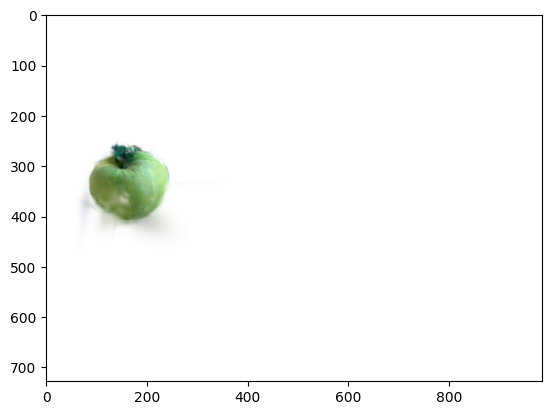

In [33]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[7], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

IndexError: list index out of range

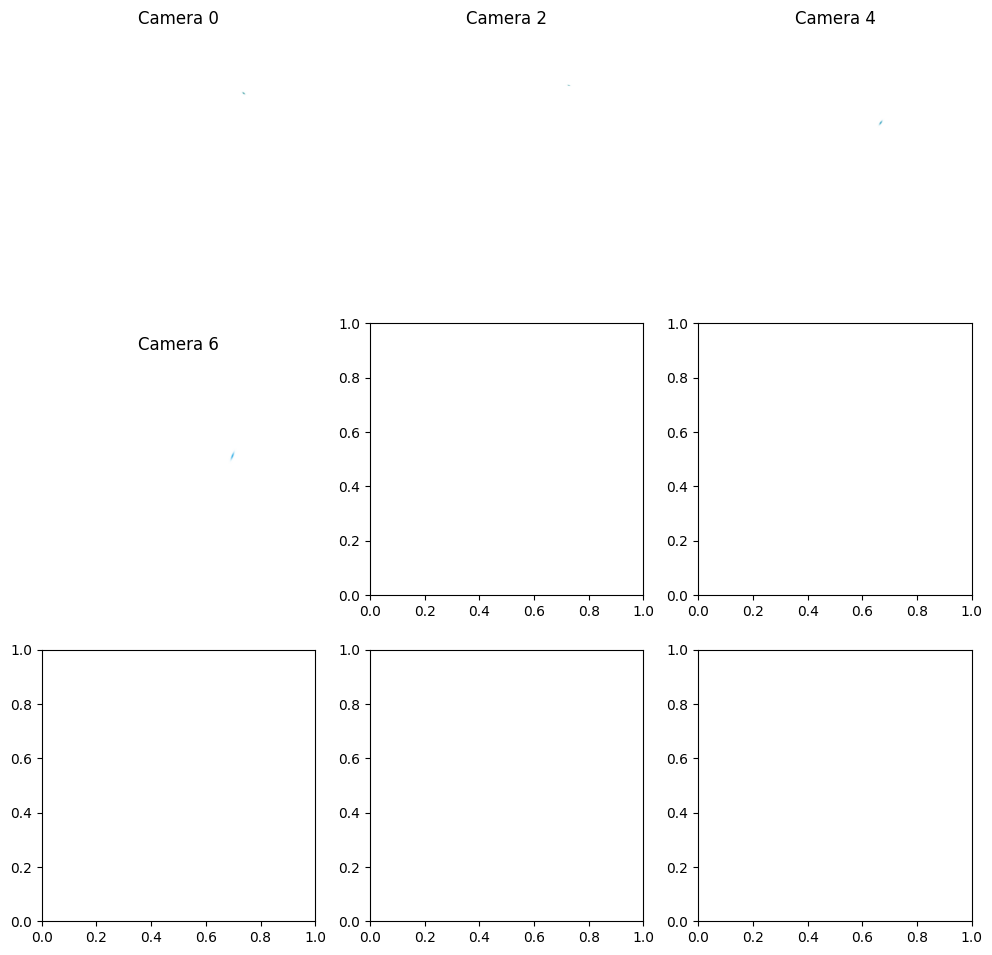

In [84]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))
for ax, cam_id in zip(axs.flatten(), [0, 2, 4, 6, 28, 30, 32, 34, 36]):
    rendered = render(cameras[cam_id], scene_gaussians, pipeline.extract(args), background)['render']
    image = rendered.permute(1, 2, 0).detach().cpu().numpy()
    ax.imshow(image)
    ax.set_title(f'Camera {cam_id}')
    ax.axis('off')
plt.tight_layout()
plt.show()


# Video / GIF

In [68]:
import imageio
# fig, axs = plt.subplots(3, 3, figsize=(12, 12))
gifFrames = [] ###
for cam_id in ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]):
    rendered = render(cameras[cam_id], scene_gaussians, pipeline.extract(args), background)['render']
    image = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)
    # ax.imshow(image)
    # ax.set_title(f'Camera {cam_id}')
    # ax.axis('off')
    gifFrames.append(image) ##
# plt.tight_layout()
# plt.show()
# gifFrames = np.array(gifFrames)
# print(gifFrames.shape)
imageio.mimwrite('cup2.gif', gifFrames, loop=65535)



# gifFrames = []
# for i in range(len(images)):
#     gifFrames.append(images[i])
# imageio.mimwrite('test.gif', gifFrames, loop=65535)

# imageio.mimwrite("test.mp4", gifFrames, fps=2, quality=10, macro_block_size=1)


# Test Views

In [38]:
test_cameras = scene.getTestCameras()
for i, cam in enumerate(test_cameras):
    print(i, cam.image_name)

0 frame_00009
1 frame_00010
2 frame_00011
3 frame_00012
4 frame_00013
5 frame_00014
6 frame_00015
7 frame_00016
8 frame_00017
9 frame_00018
10 frame_00019
11 frame_00020
12 frame_00021
13 frame_00022
14 frame_00023
15 frame_00024
16 frame_00025
17 frame_00026
18 frame_00027
19 frame_00028
20 frame_00029
21 frame_00030
22 frame_00031
23 frame_00032
24 frame_00033
25 frame_00034
26 frame_00035
27 frame_00036
28 frame_00037
29 frame_00038
30 frame_00039
31 frame_00040
32 frame_00041
33 frame_00042
34 frame_00043
35 frame_00044
36 frame_00045
37 frame_00046
38 frame_00047
39 frame_00048
40 frame_00049
41 frame_00050
42 frame_00051
43 frame_00052
44 frame_00053
45 frame_00054
46 frame_00055
47 frame_00056
48 frame_00057
49 frame_00058
50 frame_00059
51 frame_00060
52 frame_00061
53 frame_00062
54 frame_00063
55 frame_00064
56 frame_00065
57 frame_00066
58 frame_00067
59 frame_00068
60 frame_00069
61 frame_00070
62 frame_00071
63 frame_00072
64 frame_00073
65 frame_00074
66 frame_00075
67 fr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010030579..2.642977].


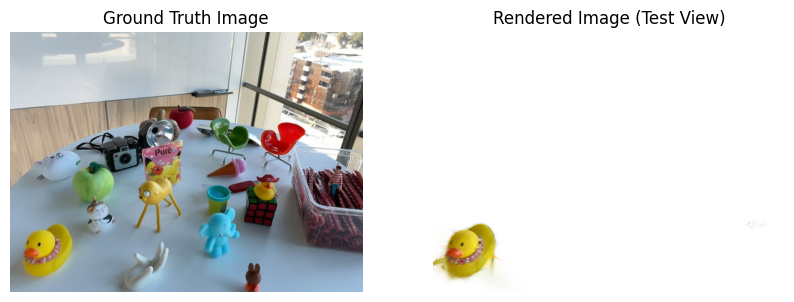

In [31]:
cam = test_cameras[8]
rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
rendered_np = rendered.permute(1, 2, 0).detach().cpu().numpy()
gt_np = cam.original_image.permute(1, 2, 0).detach().cpu().numpy()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(gt_np)
plt.title("Ground Truth Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rendered_np)
plt.title("Rendered Image (Test View)")
plt.axis('off')

plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0001002196..2.1604335].


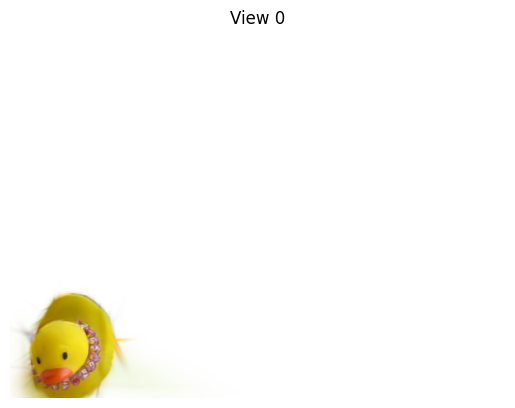

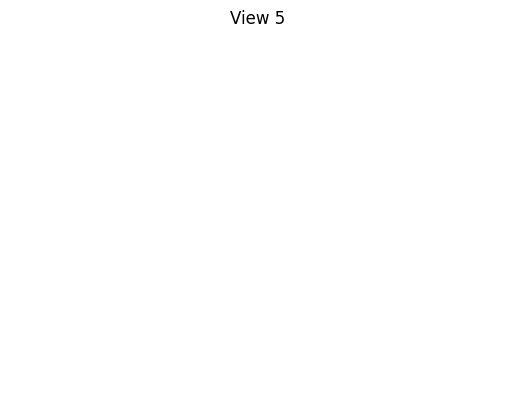

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000101640144..2.6935363].


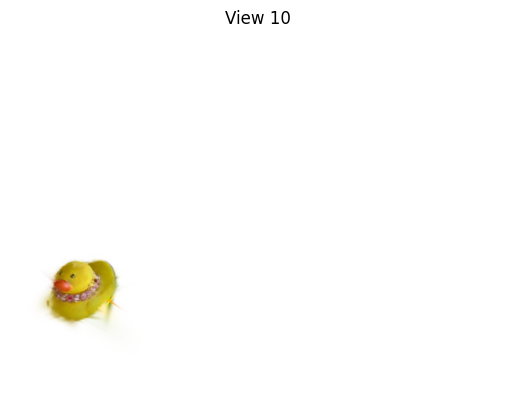

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010081983..2.1610763].


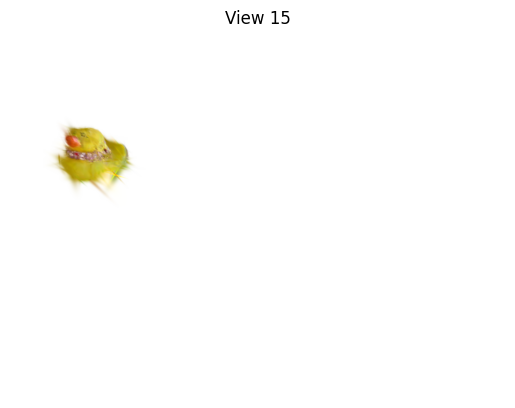

In [48]:
for idx in [0, 5, 10, 15]:
    rendered = render(test_cameras[idx], scene_gaussians, pipeline.extract(args), background)['render']
    plt.imshow(rendered.permute(1,2,0).detach().cpu())
    plt.title(f'View {idx}')
    plt.axis('off')
    plt.show()

# Generating GiF from Test views

In [39]:
import imageio

frames = []
for cam in test_cameras:
    rendered = render(cam, scene_gaussians, pipeline, background)['render']
    image = (rendered.permute(1, 2, 0).detach().cpu().numpy() * 255).astype('uint8')
    frames.append(image)

# Save the gif
imageio.mimsave('dogcc_test_views.gif', frames, fps=5)


new:

In [85]:
import imageio
import torch
import numpy as np

# --- Ensure background matches cleaned scene_gaussians ---
bg_color = [1.0 for _ in range(scene_gaussians._xyz.shape[1])]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

gifFrames = []

# Loop over the 30 selected frames
for idx in selected_indices:  # your 30 frames
    cam = all_cameras[idx]
    rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
    
    # Convert to HxWx3 uint8
    rgb_np = rendered.permute(1, 2, 0).detach().cpu().numpy()
    if rgb_np.shape[2] == 1:
        rgb_np = np.stack([rgb_np[:,:,0]]*3, axis=-1)
    rgb_np = np.clip(rgb_np, 0, 1) * 255
    rgb_np = rgb_np.astype(np.uint8)
    
    gifFrames.append(rgb_np)

# Write GIF
imageio.mimwrite('cup2_clean.gif', gifFrames, loop=0, duration=0.2)  # duration=0.2s per frame
print("GIF saved as cup2_clean.gif")


GIF saved as cup2_clean.gif


---------

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010084843..1.3534719].


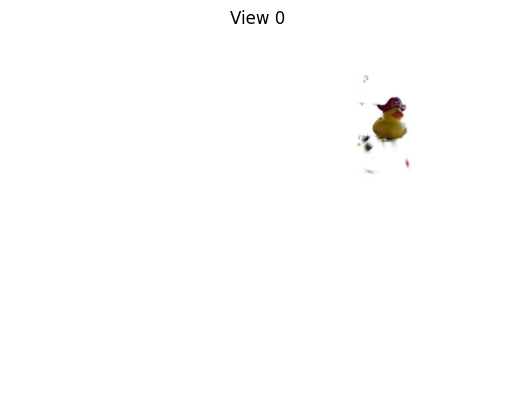

IndexError: list index out of range

In [48]:
cameras = scene.getTrainCameras()
for idx in [0, 40, 80, 120, 160, 200]:
    rendered = render(cameras[idx], scene_gaussians, pipeline.extract(args), background)['render']
    plt.imshow(rendered.permute(1,2,0).detach().cpu())
    plt.title(f'View {idx}')
    plt.axis('off')
    plt.show()


# evenly spaced views (like rotating around the object):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010084843..1.3534719].


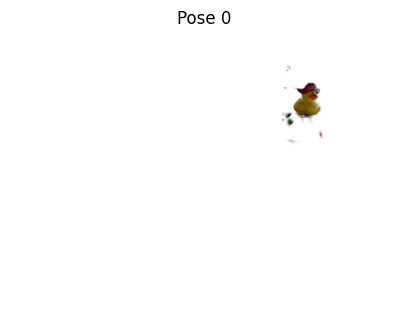

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00031093185..1.0306767].


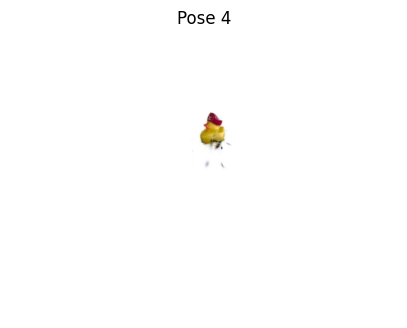

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00012633996..1.0810019].


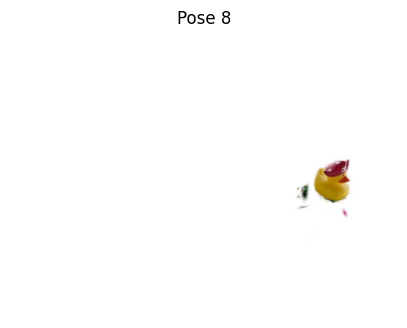

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010437081..1.0928832].


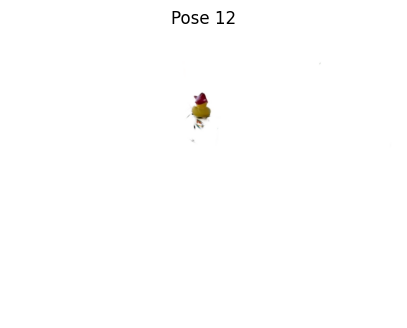

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00052407593..1.0524908].


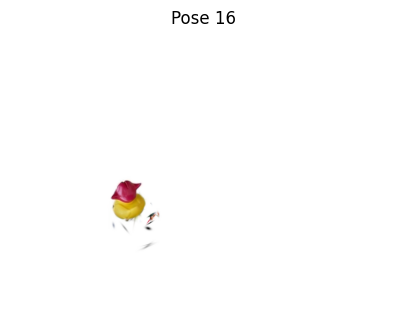

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010330054..1.3685863].


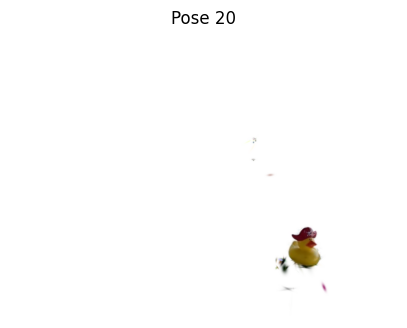

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0022828435..1.0702071].


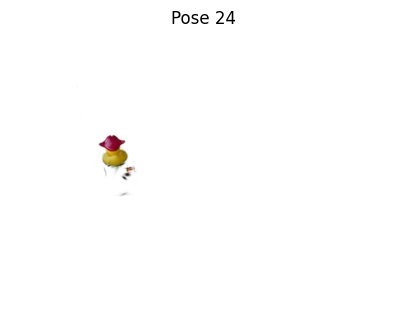

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.000329522..1.015631].


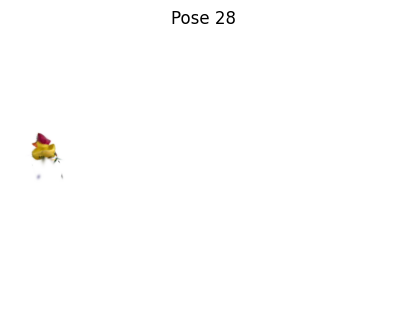

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00015172412..1.00593].


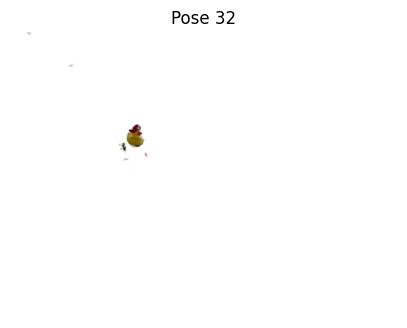

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00011010925..1.0785787].


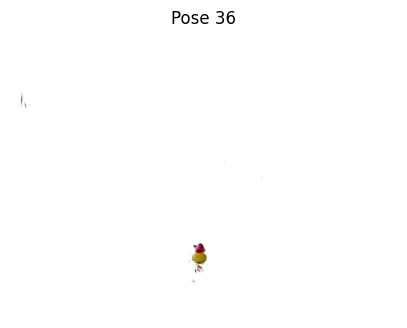

In [49]:
from copy import deepcopy

bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

train_cameras = scene.getTrainCameras()

step = len(train_cameras) // 8  # 8 views around the object
for i in range(0, len(train_cameras), step):
    cam = deepcopy(train_cameras[i])
    rendered = render(cam, scene_gaussians, pipeline.extract(args), background)['render']
    plt.figure(figsize=(5,5))
    plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
    plt.title(f"Pose {i}")
    plt.axis('off')
    plt.show()


In [50]:
print("Train cameras:", len(scene.getTrainCameras()))
print("Test cameras:", len(scene.getTestCameras()))


Train cameras: 38
Test cameras: 265


GUI result?:

In [3]:
import torch
torch.load('segmentation_res/precomputed_mask.pt')

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tensor([True, True, True,  ..., True, True, True], device='cuda:0')

Simulating orbit?

In [101]:
import math
from scene.cameras import Camera
import torch.nn.functional as F


In [106]:
# Look at matrix
def create_look_at(cam_pos, target, up=(0, 1, 0)):
    cam_pos = torch.tensor(cam_pos, dtype=torch.float32)
    target = torch.tensor(target, dtype=torch.float32)
    up = torch.tensor([0, 1, 0], dtype=torch.float32, device=cam_pos.device)

    z_axis = F.normalize(cam_pos - target, dim=0)  # camera direction
    x_axis = F.normalize(torch.cross(up, z_axis), dim=0)  # right
    y_axis = torch.cross(z_axis, x_axis)  # new up

    R = torch.stack([x_axis, y_axis, z_axis], dim=1)
    T = -R @ cam_pos[:, None]

    view_matrix = torch.eye(4)
    view_matrix[:3, :3] = R
    view_matrix[:3, 3] = T.squeeze()
    return view_matrix


In [108]:
#generate and render views
bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

# Use your scene center — approximate using camera centers
centers = torch.stack([cam.camera_center for cam in scene.getTrainCameras()])
scene_center = centers.mean(dim=0)

radius = 2.0  # distance from center
num_views = 8  # how many orbit poses

for i in range(num_views):
    angle = 2 * math.pi * i / num_views  # full circle
    x = radius * math.cos(angle)
    z = radius * math.sin(angle)
    y = 0.5  # elevation

    cam_pos = scene_center + torch.tensor([x, y, z], device=scene_center.device)
    view_matrix = create_look_at(cam_pos, scene_center)

    # Create synthetic camera
    ref_cam = scene.getTrainCameras()[0]
    custom_cam = Camera(
        colmap_id=-1,
        R=view_matrix[:3, :3],
        T=view_matrix[:3, 3],
        FoVx=ref_cam.FoVx,
        FoVy=ref_cam.FoVy,
        image=torch.zeros_like(ref_cam.original_image),
        gt_alpha_mask=torch.ones_like(ref_cam.original_image[0]),  # dummy alpha mask
        image_name=f"synthetic_{i}",
        uid=-1
    )
    custom_cam.image_height = ref_cam.image_height
    custom_cam.image_width = ref_cam.image_width

    # Render
    rendered = render(custom_cam, scene_gaussians, pipeline.extract(args), background)['render']
    plt.figure(figsize=(5, 5))
    plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
    plt.title(f"Custom Pose {i}")
    plt.axis('off')
    plt.show()


/tmp/ipykernel_2961291/2458459669.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam_pos = torch.tensor(cam_pos, dtype=torch.float32)
/tmp/ipykernel_2961291/2458459669.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target, dtype=torch.float32)


TypeError: transpose() received an invalid combination of arguments - got (), but expected one of:
 * (int dim0, int dim1)
 * (name dim0, name dim1)


In [97]:
from copy import deepcopy

# Choose N test camera views
test_cameras = scene.getTestCameras()
selected_views = test_cameras[::100] # change number here
print(selected_views)

# Set white background
bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

# Render and display each view
for idx, cam in enumerate(selected_views):
    print(idx)
    view = deepcopy(cam)
    
    rendered = render(view, scene_gaussians, pipeline.extract(args), background)['render']
    image = rendered.permute(1, 2, 0).detach().cpu().numpy()

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f'Rendered View {idx}')
    plt.axis('off')
    plt.show()


[]


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]


In [73]:
scene_gaussians.roll_back()

# Cluster in 3D

In [25]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

38323


In [26]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, cluster_selection_epsilon=0.01)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)

/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/stud/ribe/miniconda3/envs/gaussian_splatting/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92]


In [27]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [28]:
label_to_color = np.random.rand(1000, 3)
point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.5] = (0,0,0)

In [29]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [30]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[0], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

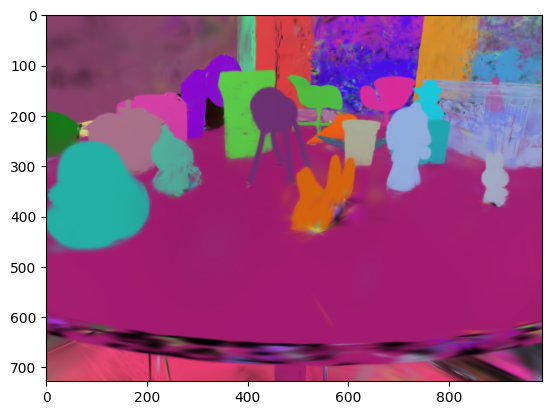

In [31]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

Skip Language/clip related for now

# NEW - Render from different camera views

In [35]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[20], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

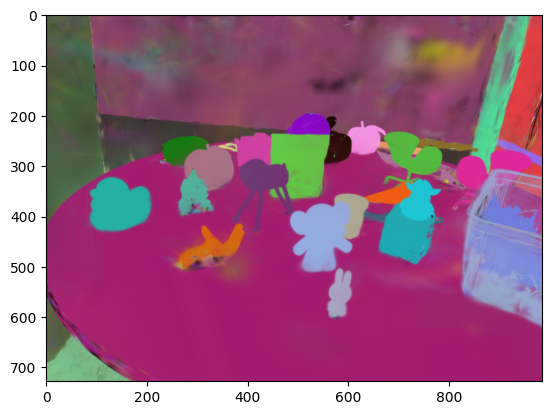

In [36]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

To render from test or all cameras:

In [47]:
test_cameras = scene.getTestCameras()
# selected_cameras = test_cameras[::10]  # Take every 20th camera for diversity
selected_cameras = test_cameras


In [48]:
bg_color = [0 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

for idx, cam in enumerate(selected_cameras):
    view = deepcopy(cam)
    rendered = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)
    rendered_image = rendered['render'].permute(1,2,0).detach().cpu().numpy()

    plt.figure(figsize=(5,5))
    plt.imshow(rendered_image[:,:,:3])
    plt.title(f'View {idx}')
    plt.axis('off')
    plt.show()


In [49]:
from PIL import Image

output_dir = './view_renders'
os.makedirs(output_dir, exist_ok=True)

for idx, cam in enumerate(selected_cameras):
    ...
    img = (rendered_image[:,:,:3] * 255).astype(np.uint8)
    Image.fromarray(img).save(f'{output_dir}/view_{idx:02d}.png')


# #TODO: Render input views for diffusion model

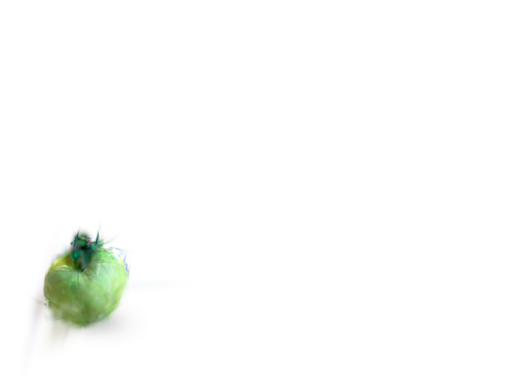

Saved diffusion_input/duckcc_view_004.png


In [35]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Make sure output folder exists
os.makedirs("diffusion_input", exist_ok=True)

# Pick which test view you want
test_cameras = scene.getTestCameras()
view_idx = 4  # change index 
cam = test_cameras[view_idx]

# Render that camera
rendered = render(cam, scene_gaussians, pipeline, background)['render']

# Convert to HxWx3 uint8
rgb_np = rendered.permute(1, 2, 0).detach().cpu().numpy()
rgb_np = np.clip(rgb_np, 0, 1) * 255
rgb_np = rgb_np.astype(np.uint8)

# Visualization (in notebook) 
plt.imshow(rgb_np)
plt.axis("off")
plt.show()

# Save as PNG in diffusion_inputs
save_path = os.path.join("diffusion_input", f"duckcc_view_{view_idx:03d}.png")
cv2.imwrite(save_path, cv2.cvtColor(rgb_np, cv2.COLOR_RGB2BGR))
print(f"Saved {save_path}")


# #TODO: Integrate zero123++ pipeline

In [ ]:
import torch
from PIL import Image
from diffusers import DiffusionPipeline, EulerAncestralDiscreteScheduler
import os

# Folders
input_dir = "diffusion_input"
output_dir = "diffusion_output"
os.makedirs(output_dir, exist_ok=True)

# Load the pipeline
pipeline = DiffusionPipeline.from_pretrained(
    "sudo-ai/zero123plus-v1.1",
    custom_pipeline="sudo-ai/zero123plus-pipeline",
    torch_dtype=torch.float16
)

pipeline.scheduler = EulerAncestralDiscreteScheduler.from_config(
    pipeline.scheduler.config, timestep_spacing='trailing'
)
pipeline.to('cuda:0')

# Pick one input image 
input_path = os.path.join(input_dir, "duckcc_view_004.png")  #  update if needed
cond = Image.open(input_path).convert("RGB")

# Run Zero123++
result = pipeline(cond, num_inference_steps=50).images[0]  # try 28–75 steps

# Show + Save
# result.show()
output_path = os.path.join(output_dir, "duckcc_view_004_out.png")
result.save(output_path)

print(f"Saved generated view to {output_path}")


text_encoder/model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Saved generated view to diffusion_output/duckcc_view_004_out.png


Error: no "view" rule for type "image/png" passed its test case
       (for more information, add "--debug=1" on the command line)
